In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster, HeatMap
from folium import Icon
from geopy.distance import geodesic  
from IPython.display import display
import random 
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

In [2]:
# Load the dataset
file_path = 'bern_detectors.csv'  # Adjust the file path
df = pd.read_csv(file_path)

# Display basic information about the dataset
print("Dataset Information:")
df.info()

# Display the first few rows to understand the structure
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
print(df.describe())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  755 non-null    int64  
 1   detid       755 non-null    object 
 2   length      755 non-null    float64
 3   pos         755 non-null    float64
 4   fclass      755 non-null    object 
 5   road        720 non-null    object 
 6   limit       755 non-null    int64  
 7   citycode    755 non-null    object 
 8   lanes       755 non-null    float64
 9   linkid      755 non-null    float64
 10  long        755 non-null    float64
 11  lat         755 non-null    float64
dtypes: float64(6), int64(2), object(4)
memory usage: 70.9+ KB

First 5 rows of the dataset:
   Unnamed: 0      detid    length       pos     fclass                  road  \
0         794  K123.D4.2  0.446927  0.028676   tertiary       Morillonstrasse   
1         795  K024.D4.3  0.072176  0.001133 

###### **Dataset Structure**
- **Total Rows**: 755
- **Total Columns**: 12
- **Column Details**:
  - **Unnamed: 0**: Likely an index or redundant column.
  - **detid**: Identifier for the detector (string).
  - **length**: Length of the road section (numeric).
  - **pos**: Position of the detector (numeric).
  - **fclass**: Road classification (e.g., tertiary, secondary; categorical).
  - **road**: Name of the road (string).
  - **limit**: Speed limit (numeric).
  - **citycode**: City code (likely indicating "bern"; categorical).
  - **lanes**: Number of lanes (numeric).
  - **linkid**: Identifier for the link (numeric).
  - **long**: Longitude (numeric).
  - **lat**: Latitude (numeric).



# Data Cleaning/Imputation

In [5]:
# Drop duplicate rows
df = df.drop_duplicates()

# Verify that duplicates have been removed
print("After dropping duplicates:")
print(df.shape)  # Shows the new shape (number of rows and columns)


After dropping duplicates:
(755, 12)


In [6]:
def show_detaleis():
    global df
    for col in df.columns:
        print(f'for feature  {col}')
        print(f'number of Nulls  {df[col].isna().sum()}')
        print (f'number of unique values is  {len(df[col].unique())}')
        print(f'unique values is  {df[col].unique()}')
        print('\n\n==================================\n\n')
show_detaleis()

for feature  Unnamed: 0
number of Nulls  0
number of unique values is  755
unique values is  [ 794  795  796  797  798  799  800  801  802  803  804  805  806  807
  808  809  810  811  812  813  814  815  816  817  818  819  820  821
  822  823  824  825  826  827  828  829  830  831  832  833  834  835
  836  837  838  839  840  841  842  843  844  845  846  847  848  849
  850  851  852  853  854  855  856  857  858  859  860  861  862  863
  864  865  866  867  868  869  870  871  872  873  874  875  876  877
  878  879  880  881  882  883  884  885  886  887  888  889  890  891
  892  893  894  895  896  897  898  899  900  901  902  903  904  905
  906  907  908  909  910  911  912  913  914  915  916  917  918  919
  920  921  922  923  924  925  926  927  928  929  930  931  932  933
  934  935  936  937  938  939  940  941  942  943  944  945  946  947
  948  949  950  951  952  953  954  955  956  957  958  959  960  961
  962  963  964  965  966  967  968  969  970  971  972

In [7]:
# Drop the "Unnamed: 0" column
df = df.drop(columns=["Unnamed: 0"])

# Handle missing values in 'road' column
# Option 1: Fill missing values with the most frequent value (mode)
df['road'] = df['road'].fillna(df['road'].mode()[0])

# Alternatively, you could drop rows with missing 'road' information:
# df = df.dropna(subset=['road'])

# Verify the changes
print("\nAfter handling missing data:")
print(df.isnull().sum())




After handling missing data:
detid       0
length      0
pos         0
fclass      0
road        0
limit       0
citycode    0
lanes       0
linkid      0
long        0
lat         0
dtype: int64


In [8]:
# Assuming your dataset is called df

# Step 1: Create 'location_cluster' based on 'fclass' (just an example, you can use other methods for clustering)
df['location_cluster'] = df['fclass'].astype('category').cat.codes  # Convert 'fclass' to a numeric cluster code

# Step 2: Calculate 'distance_to_center' using the Haversine formula
bern_center = (46.94809, 7.44744)  # Latitude and Longitude of Bern city center

def calculate_distance(lat, long, center=bern_center):
    return geodesic((lat, long), center).km  # Returns distance in kilometers

df['distance_to_center'] = df.apply(lambda row: calculate_distance(row['lat'], row['long']), axis=1)

# Verify the changes
df[['detid', 'location_cluster', 'distance_to_center']].head()


detid  location_cluster  distance_to_center
0  K123.D4.2                 7            1.761230
1  K024.D4.3                 5            0.585708
2  K123.D1.2                 7            1.687586
3  K123.D1.1                 7            1.700112
4  K078.D2.4                 5            1.290907

In [9]:
# Load the new dataset (bern_uniform.csv)
new_data_path = 'bern_uniform.csv'
bern_uniform_df = pd.read_csv(new_data_path)

# Display basic information and the first few rows of the new dataset
bern_uniform_info = bern_uniform_df.info()
bern_uniform_head = bern_uniform_df.head()

bern_uniform_info, bern_uniform_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2015 entries, 0 to 2014
Columns: 472 entries, datetime to K171.SD5
dtypes: float64(471), object(1)
memory usage: 7.3+ MB


(None,
               datetime  K001.D4.2  K001.D6.1  K001.D6.2  K001.D6.3  K001.D6.4  \
 0  2016-10-24 00:05:00       59.8        0.0        0.0        0.0       36.0   
 1  2016-10-24 00:10:00       12.2       12.0        0.0       12.0        0.0   
 2  2016-10-24 00:15:00       36.0        NaN       11.8       11.8       35.8   
 3  2016-10-24 00:20:00       12.0       24.0       12.2       12.2        0.2   
 4  2016-10-24 00:25:00       35.8       12.0       12.0       12.0       12.0   
 
    K001.D6.5  K001.D6.6  K002.D5.3  K002.SD7  ...  K163.D9.20  K163.D9.21  \
 0       36.0       36.0       12.0      47.8  ...        24.2        24.2   
 1        0.0        0.0       24.0      12.2  ...         0.0         0.0   
 2       35.8       35.8       11.8      24.0  ...         0.0         0.0   
 3        0.2        0.2        0.2       0.0  ...        24.0        24.0   
 4       12.0       12.0       23.8       0.0  ...        12.0        12.0   
 
    K163.D9.22  K165.D2.1  K1

In [10]:
bern_uniform_df.isna().sum()

datetime        0
K001.D4.2    1157
K001.D6.1     873
K001.D6.2     870
K001.D6.3     875
             ... 
K165.D2.3     303
K165.D4.1     319
K165.D4.2     336
K169.D4.2     576
K171.SD5        0
Length: 472, dtype: int64

In [11]:
#it gives all the columns that contains some null values
feature_na=[feature for feature in bern_uniform_df.columns if bern_uniform_df[feature].isnull().sum()>0] 
print(len(feature_na))
feature_na

443


['K001.D4.2',
 'K001.D6.1',
 'K001.D6.2',
 'K001.D6.3',
 'K001.D6.4',
 'K001.D6.5',
 'K001.D6.6',
 'K002.D5.3',
 'K002.SD7',
 'K003.D12.1',
 'K003.D13.1',
 'K003.D14.1',
 'K003.D2.2',
 'K003.D4.1',
 'K005.D2.2',
 'K005.D2.3',
 'K005.D38.3',
 'K005.D6.1',
 'K006.D7.1',
 'K006.D7.2',
 'K006.SD7.3',
 'K007.D3.1',
 'K007.D3.2',
 'K007.D6.1',
 'K007.D6.2',
 'K008.D1.1',
 'K008.D2.1',
 'K009.D18.1',
 'K009.D19.2',
 'K012.D6.1',
 'K013.D2.1',
 'K013.D2.2',
 'K013.D2.3',
 'K013.D3.1',
 'K013.D3.2',
 'K013.D4.1',
 'K013.D4.2',
 'K013.D4.4',
 'K013.D4.5',
 'K013.D5.1',
 'K013.D5.3',
 'K013.D5.5',
 'K013.D5.6',
 'K014.D1.1',
 'K014.D1.2',
 'K014.D2.1',
 'K014.D2.2',
 'K014.D2.3',
 'K014.D2.4',
 'K014.D2.6',
 'K014.D5.1',
 'K014.D5.4',
 'K015.D1.1',
 'K015.D1.2',
 'K016.D1.1',
 'K017.D1.1',
 'K017.D1.2',
 'K017.D25.1',
 'K017.D25.2',
 'K017.D33.1',
 'K017.D4.1',
 'K018.D11.1',
 'K018.D23.1',
 'K018.D3.1',
 'K021.D6.1',
 'K023.D1.2',
 'K023.D1.3',
 'K023.D16.1',
 'K023.D16.3',
 'K023.D16.4',
 'K023

In [12]:
# this gives you the percentage of missing values
for feature in feature_na:
    print('{} has {} % missing values'.format(feature,np.round(bern_uniform_df[feature].isnull().sum()/len(df)*100,4)))


K001.D4.2 has 153.245 % missing values
K001.D6.1 has 115.6291 % missing values
K001.D6.2 has 115.2318 % missing values
K001.D6.3 has 115.894 % missing values
K001.D6.4 has 76.6887 % missing values
K001.D6.5 has 76.2914 % missing values
K001.D6.6 has 1.1921 % missing values
K002.D5.3 has 38.543 % missing values
K002.SD7 has 114.702 % missing values
K003.D12.1 has 129.404 % missing values
K003.D13.1 has 2.1192 % missing values
K003.D14.1 has 76.5563 % missing values
K003.D2.2 has 114.3046 % missing values
K003.D4.1 has 0.7947 % missing values
K005.D2.2 has 77.0861 % missing values
K005.D2.3 has 77.8808 % missing values
K005.D38.3 has 79.6026 % missing values
K005.D6.1 has 3.5762 % missing values
K006.D7.1 has 5.5629 % missing values
K006.D7.2 has 6.3576 % missing values
K006.SD7.3 has 16.4238 % missing values
K007.D3.1 has 0.1325 % missing values
K007.D3.2 has 0.1325 % missing values
K007.D6.1 has 76.2914 % missing values
K007.D6.2 has 76.4238 % missing values
K008.D1.1 has 0.6623 % miss

In [13]:
# drop columns with missing data > 50%
missing_data = (bern_uniform_df.isnull().sum() / bern_uniform_df.shape[0]) * 100
criteria = missing_data <= 50

bern_uniform_df = bern_uniform_df.loc[:, bern_uniform_df.columns[criteria]]
print('shape of data: {}'.format(bern_uniform_df.shape))
print('% null per column:')

# preview new columns and % null values
(bern_uniform_df
 .isnull()
 .sum()
 .div(bern_uniform_df.shape[0])
 .mul(100)
 .sort_values(ascending=False)
)

shape of data: (2015, 431)
% null per column:


K040.D7.3     48.982630
K003.D12.1    48.486352
K051.D6.1     46.997519
K040.D9.2     46.550868
K040.D7.2     45.210918
                ...    
K070.D2.3      0.000000
K077.D8.4      0.000000
K120.D2.2      0.000000
K126.D2.1      0.000000
K171.SD5       0.000000
Length: 431, dtype: float64

In [14]:
# Step 1: Fill NaN values with the median of each column (excluding the first column)
bern_uniform_df.iloc[:, 1:] = bern_uniform_df.iloc[:, 1:].apply(lambda col: col.fillna(col.median()) if col.dtype in ['float64', 'int64'] else col)

# Step 2: Convert all columns (except the first one) to float64
bern_uniform_df.iloc[:, 1:] = bern_uniform_df.iloc[:, 1:].astype('float64')

#it gives all the columns that contains some null values
feature_na=[feature for feature in bern_uniform_df.columns if bern_uniform_df[feature].isnull().sum()>0] 
print(len(feature_na))
feature_na


0


[]

In [17]:
df.columns

Index(['detid', 'length', 'pos', 'fclass', 'road', 'limit', 'citycode',
       'lanes', 'linkid', 'long', 'lat', 'location_cluster',
       'distance_to_center'],
      dtype='object')

<Figure size 1200x600 with 0 Axes>

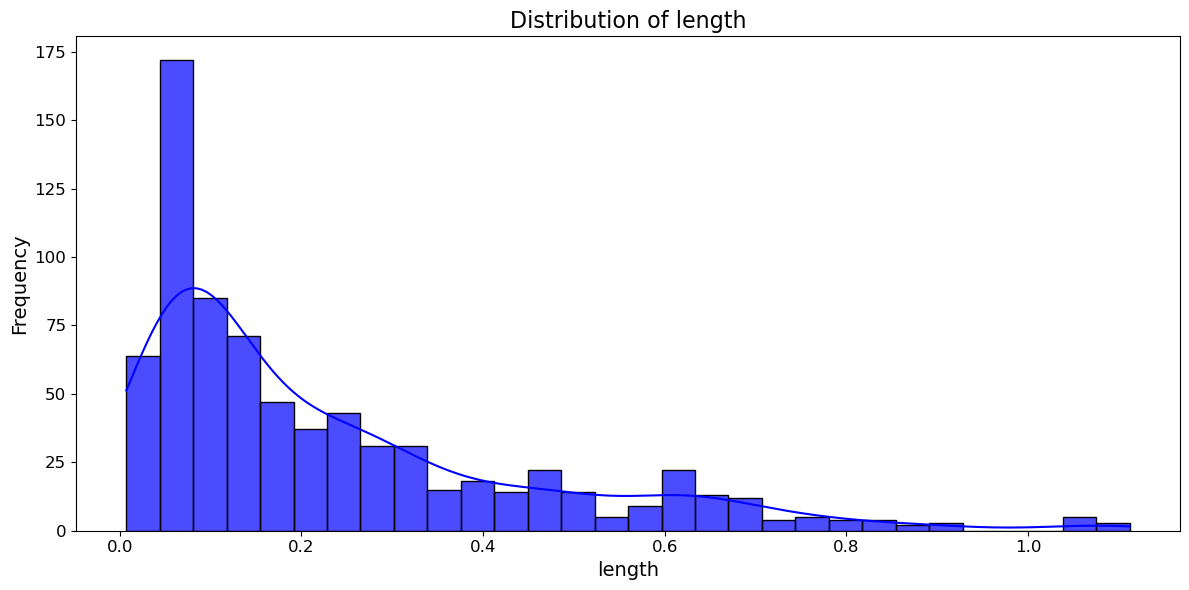

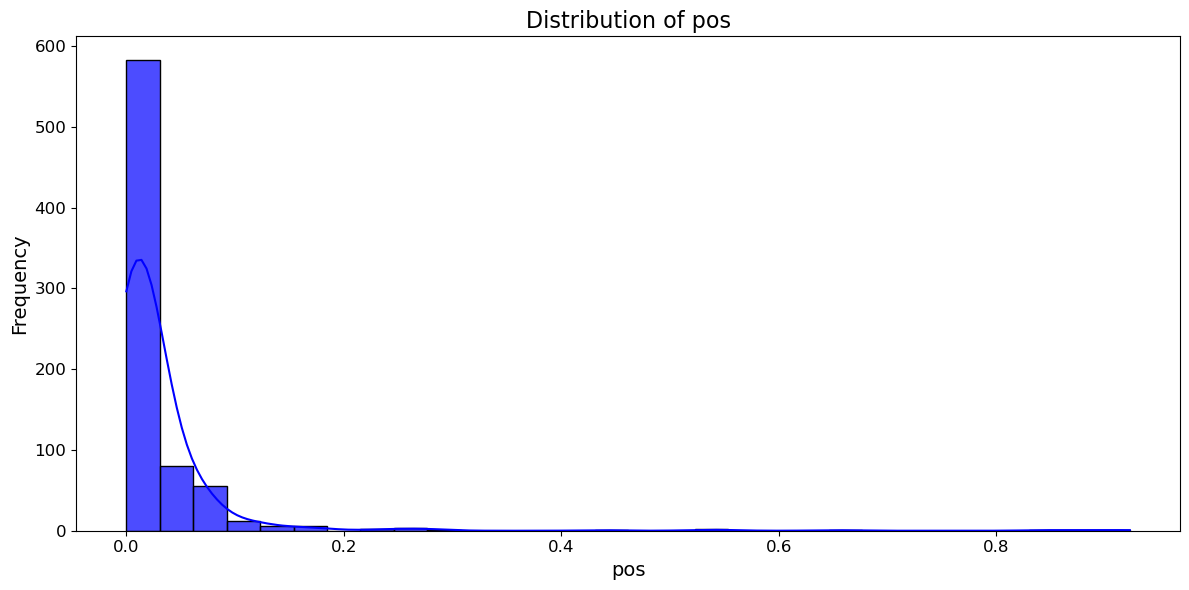

C:\Users\moham\AppData\Local\Temp\ipykernel_12668\2814332732.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index[:20], palette="viridis")


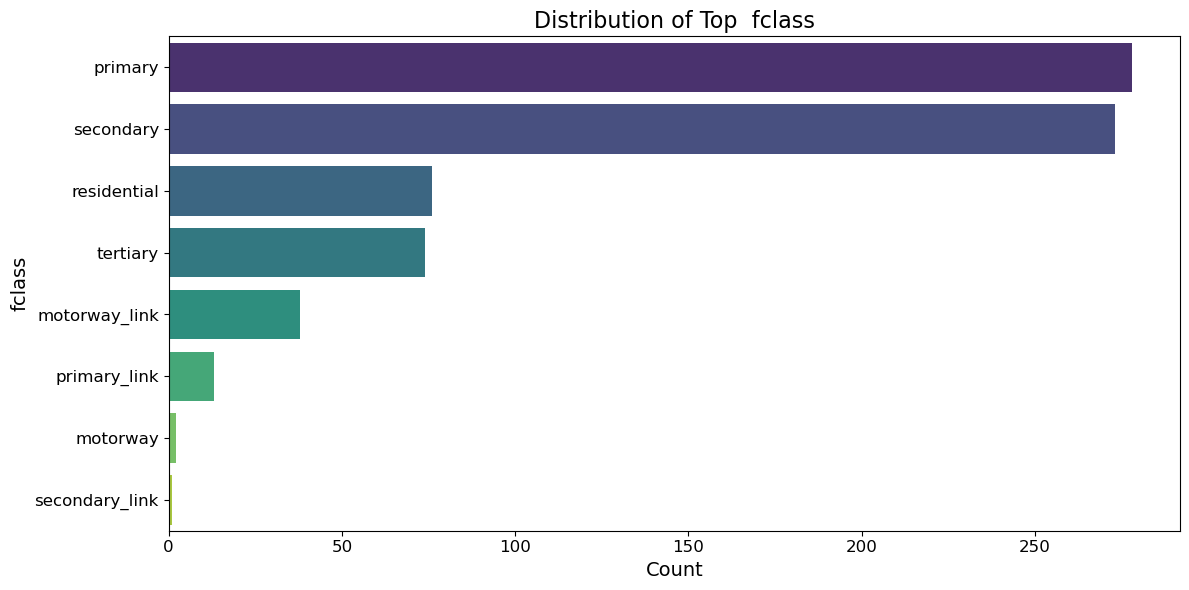

C:\Users\moham\AppData\Local\Temp\ipykernel_12668\2814332732.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index[:20], palette="viridis")


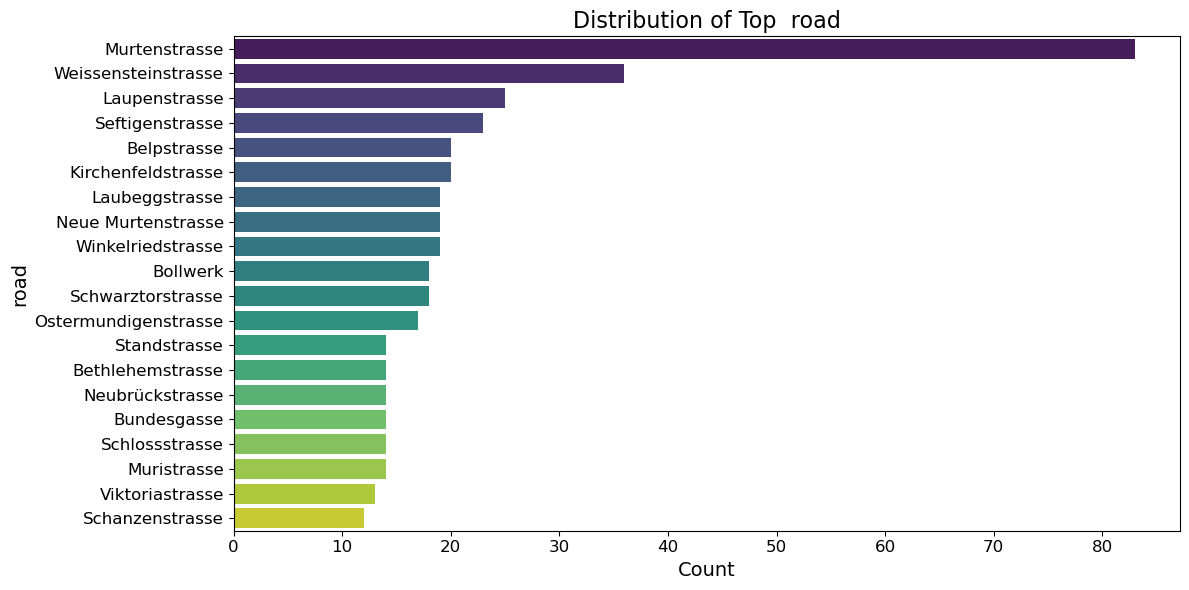

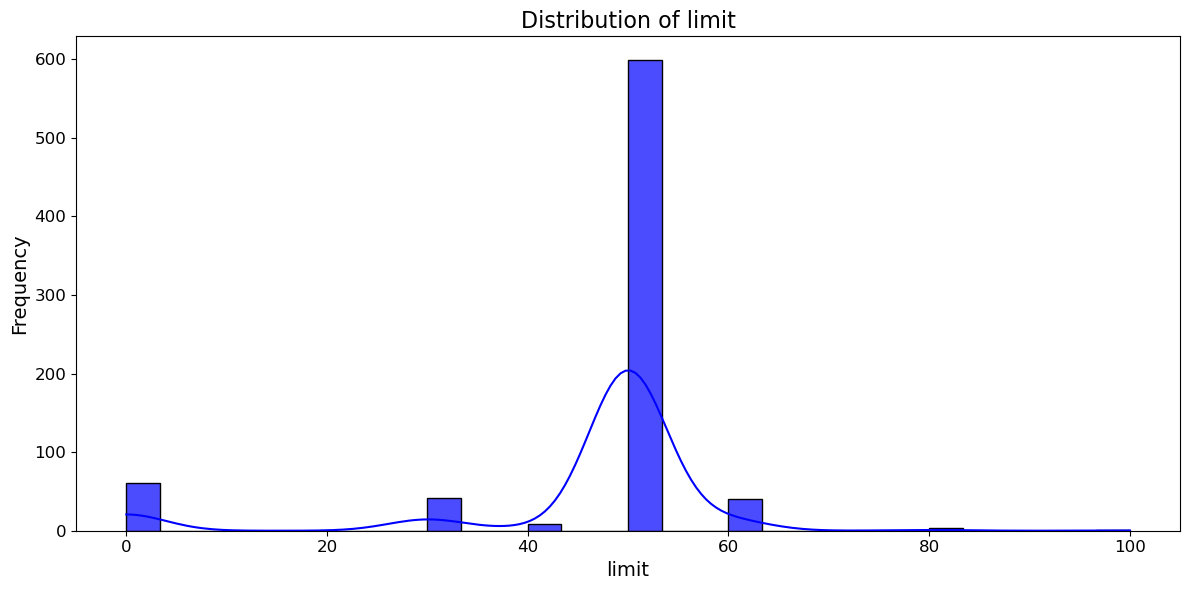

C:\Users\moham\AppData\Local\Temp\ipykernel_12668\2814332732.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index[:20], palette="viridis")


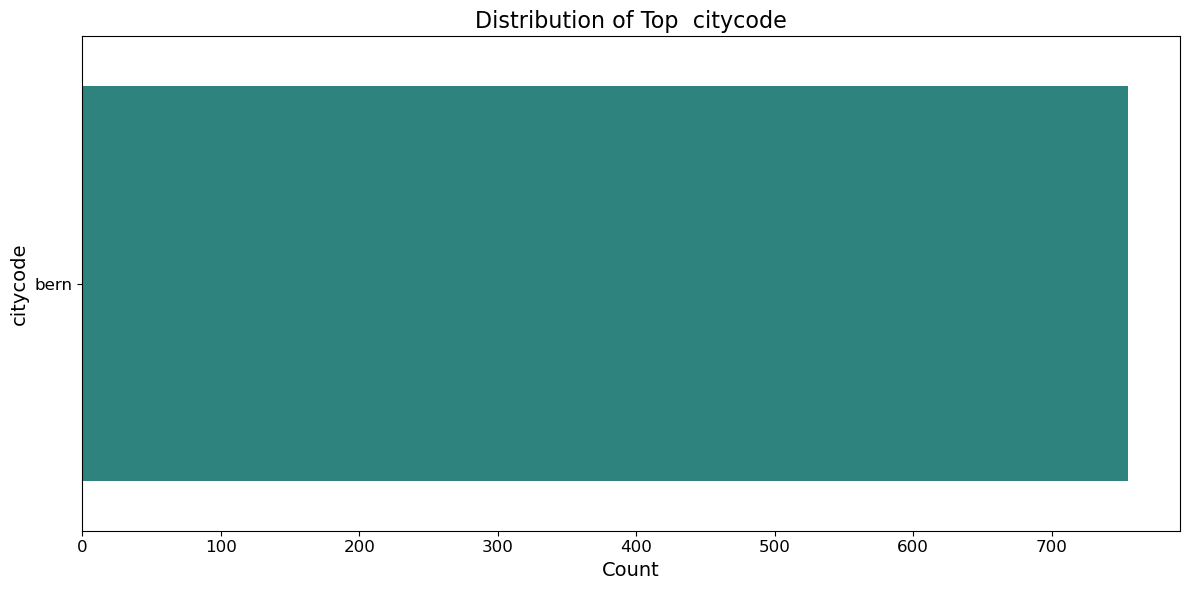

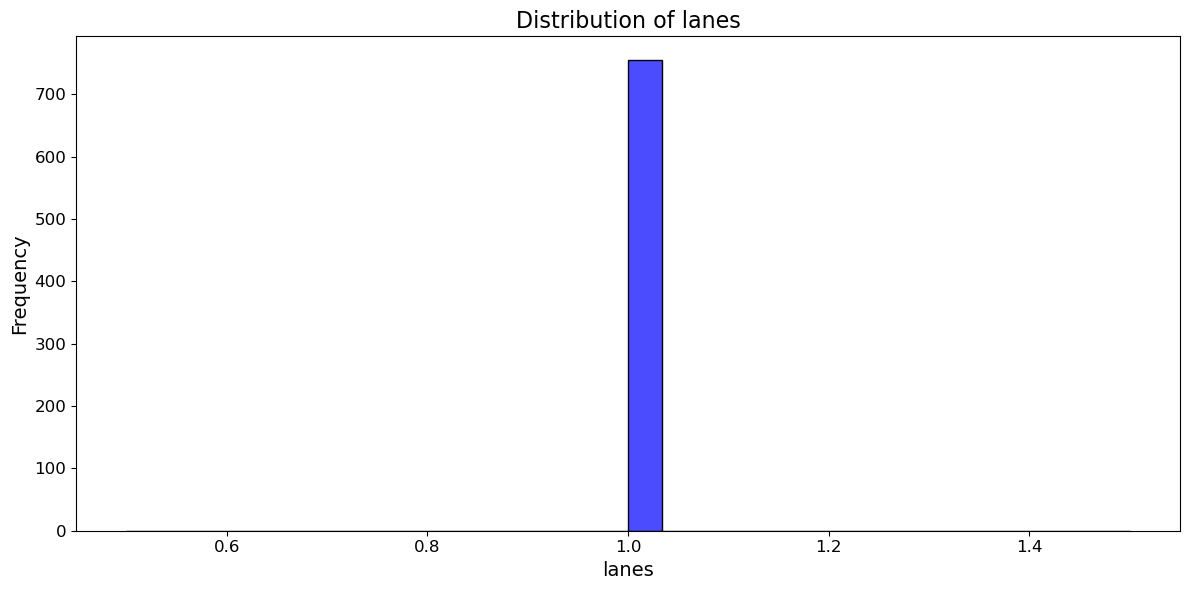

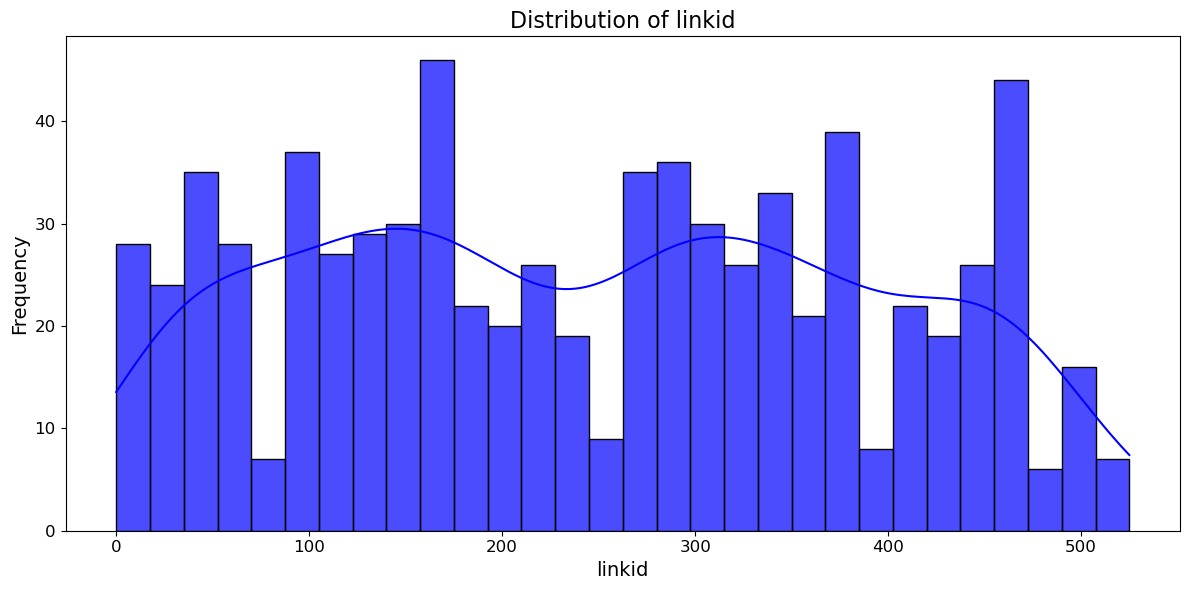

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

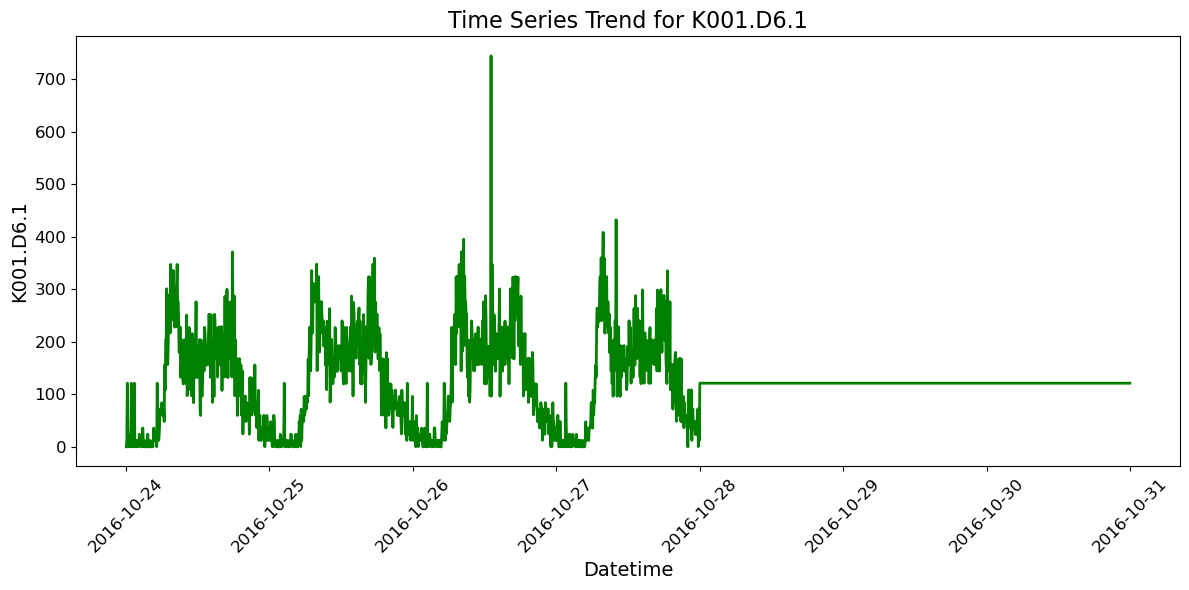

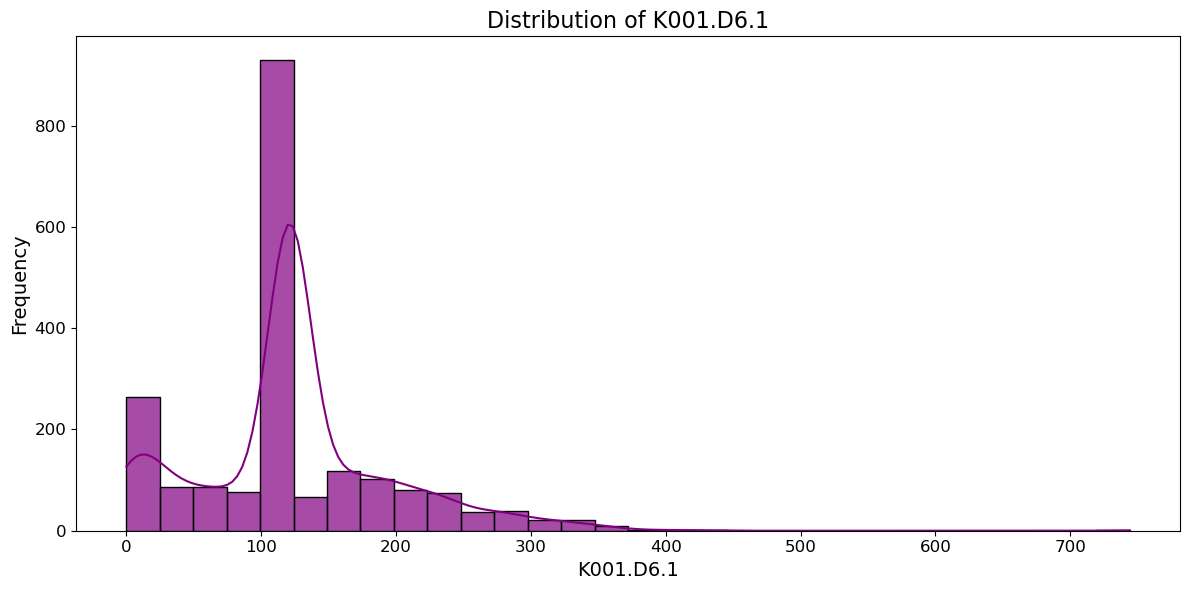

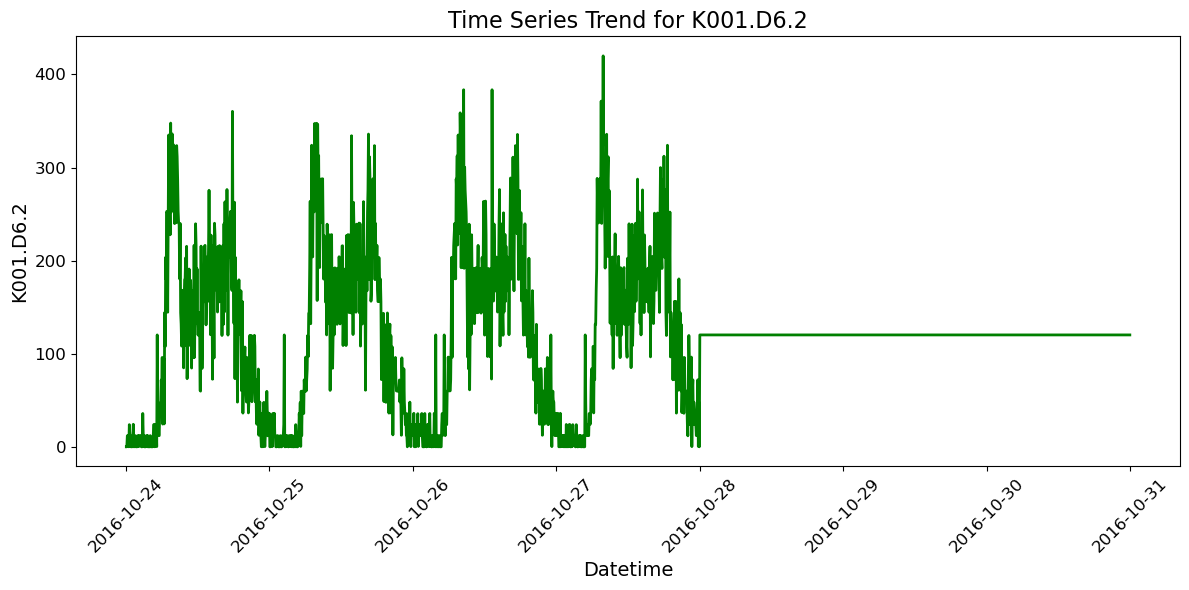

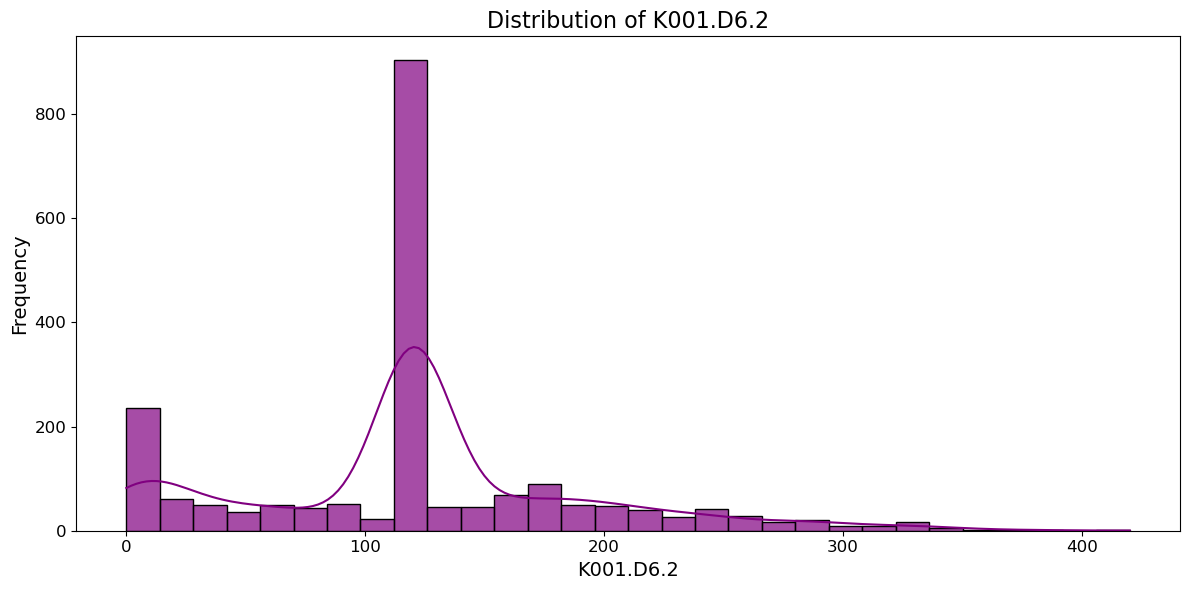

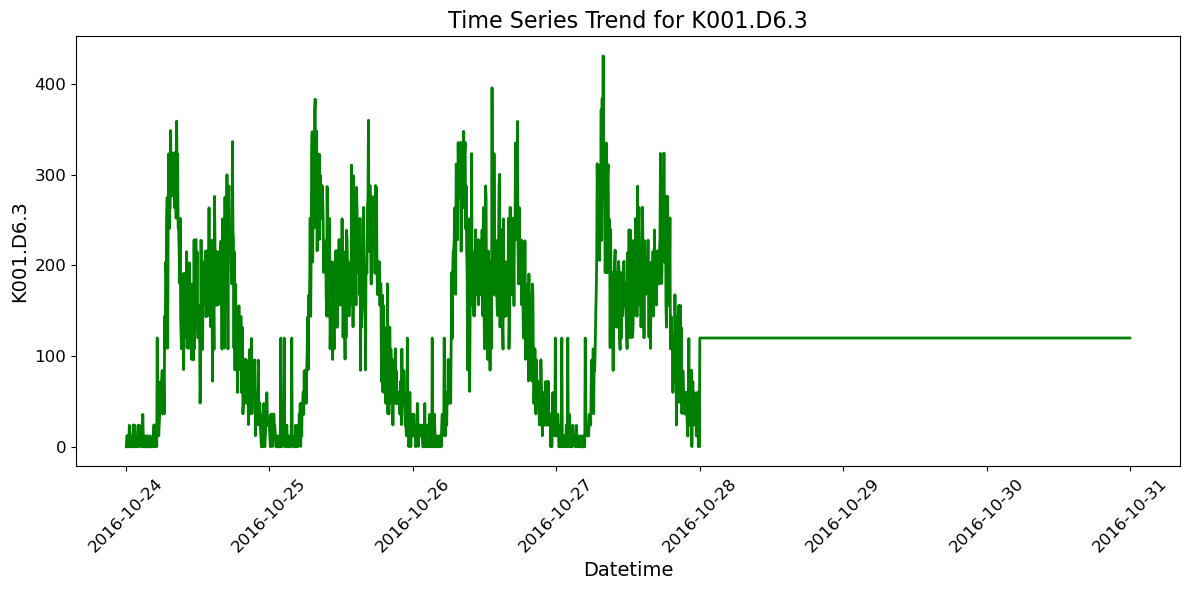

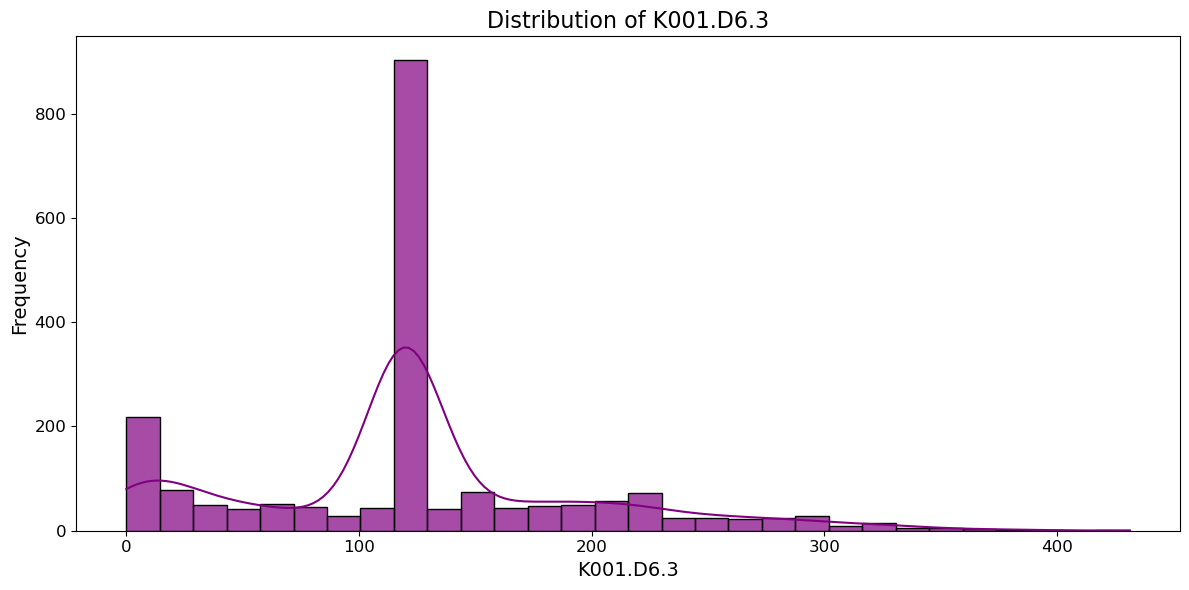

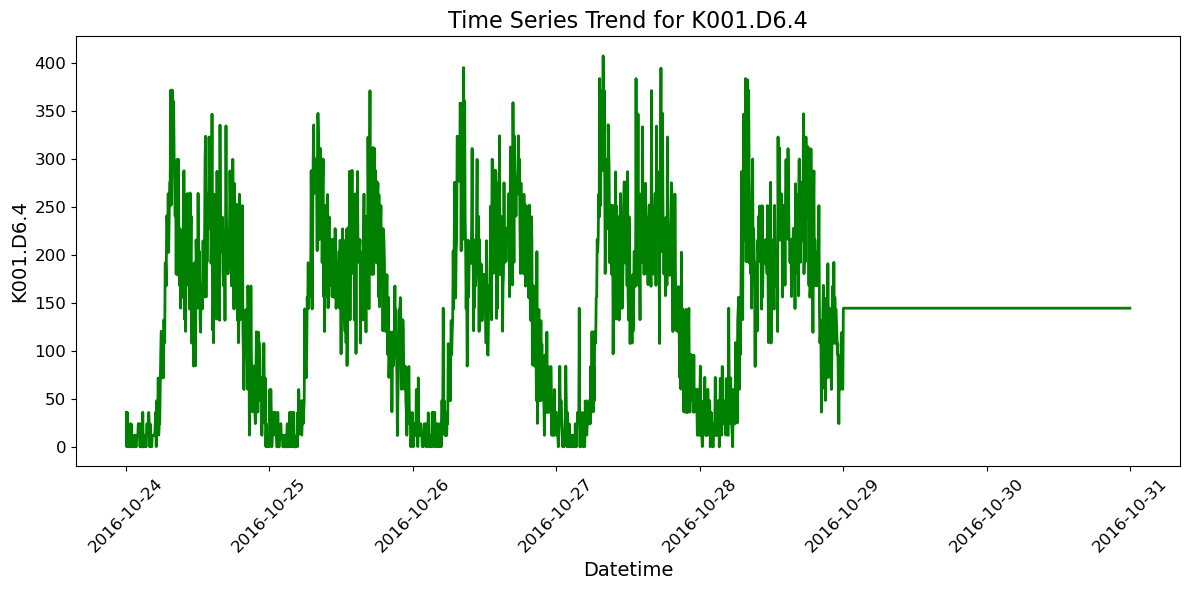

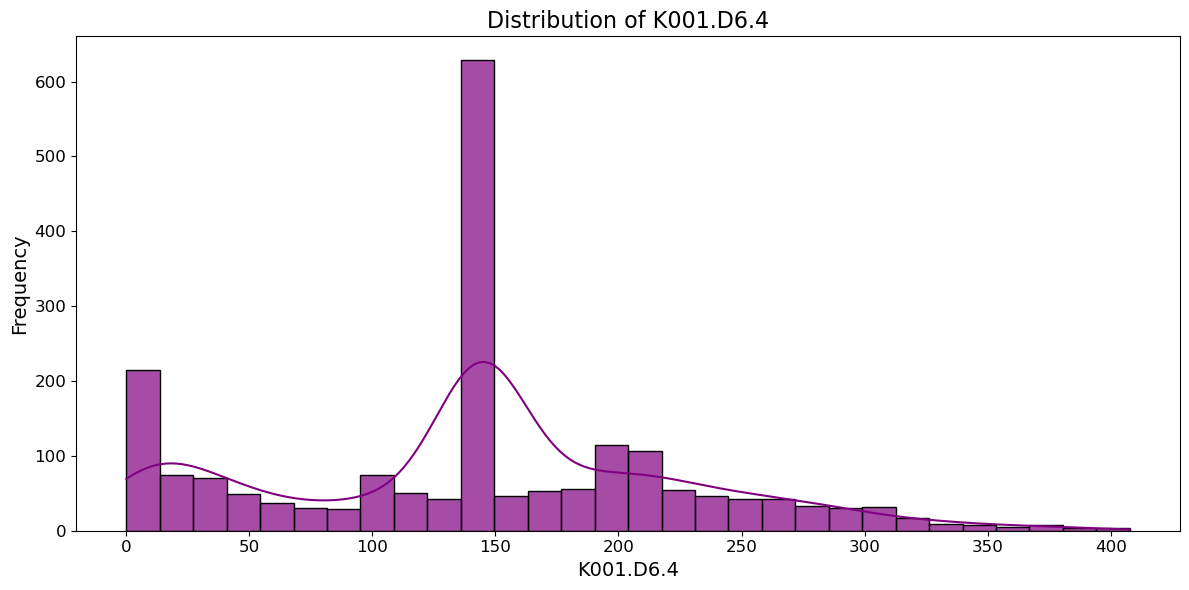

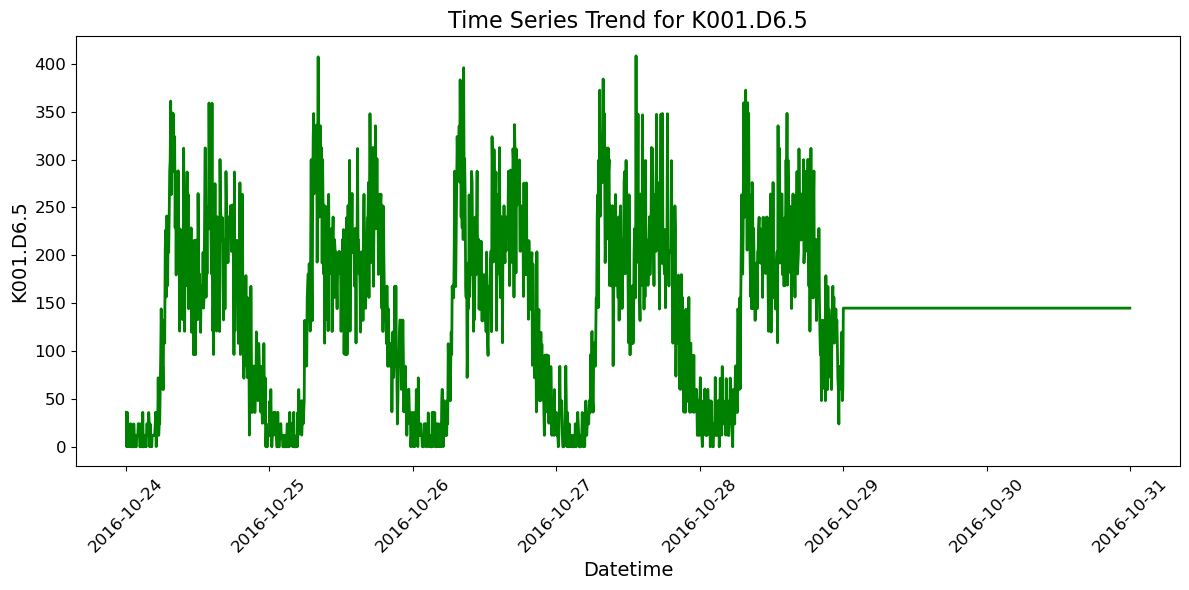

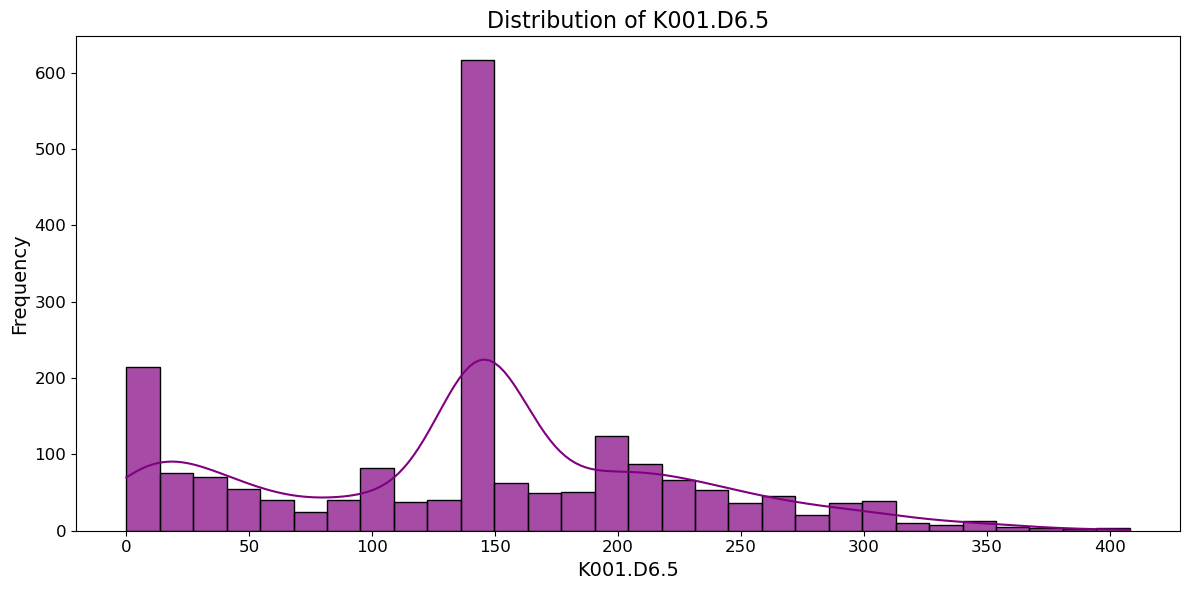

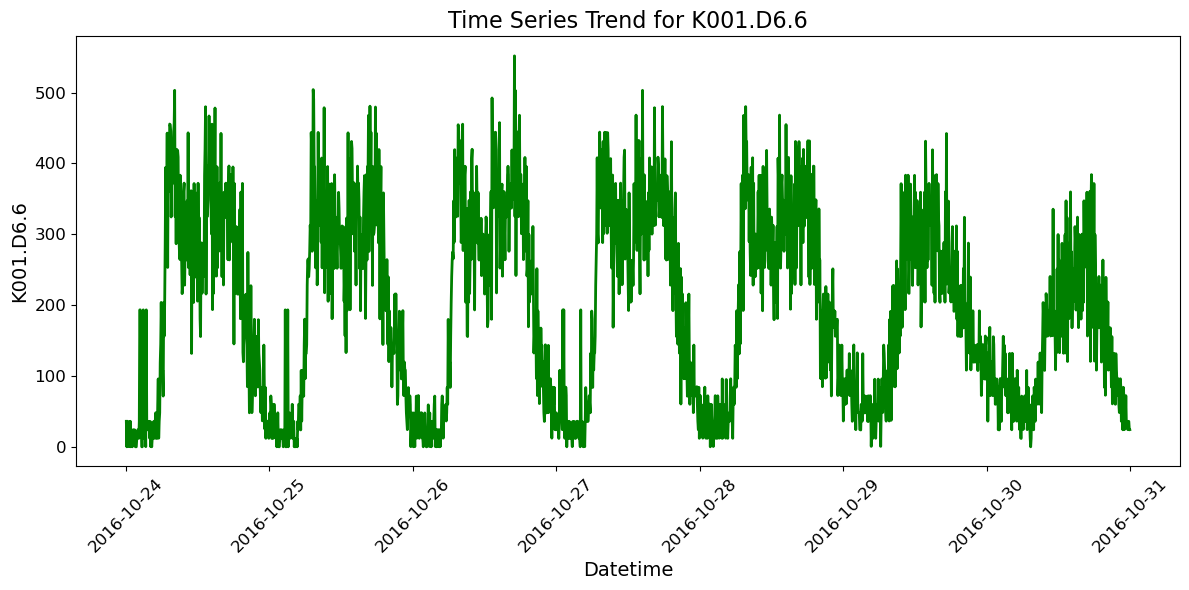

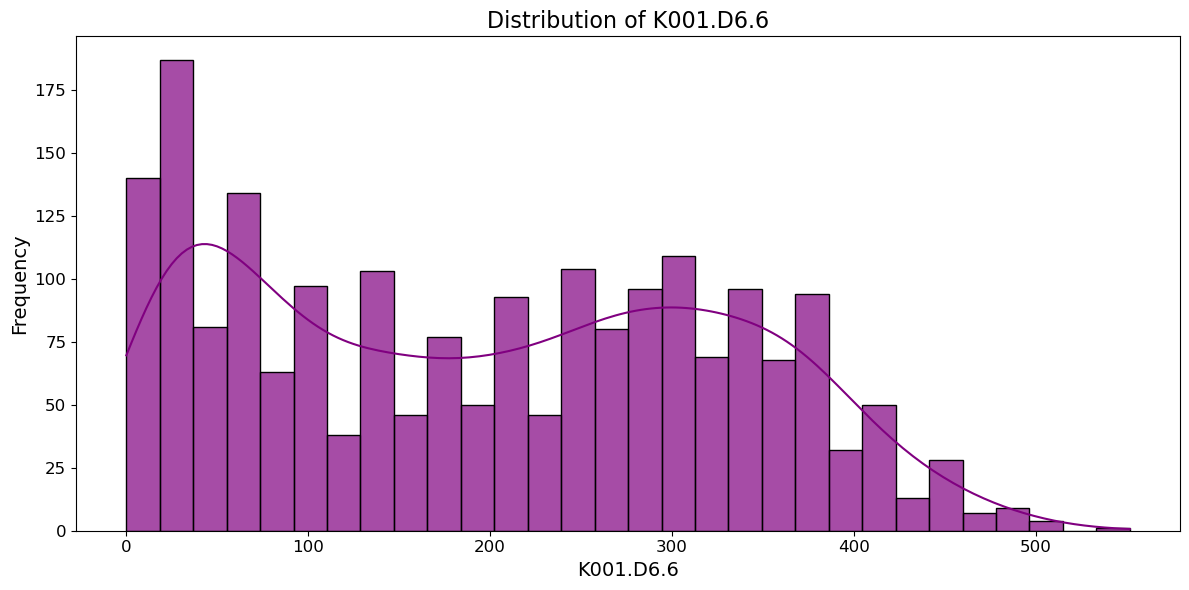

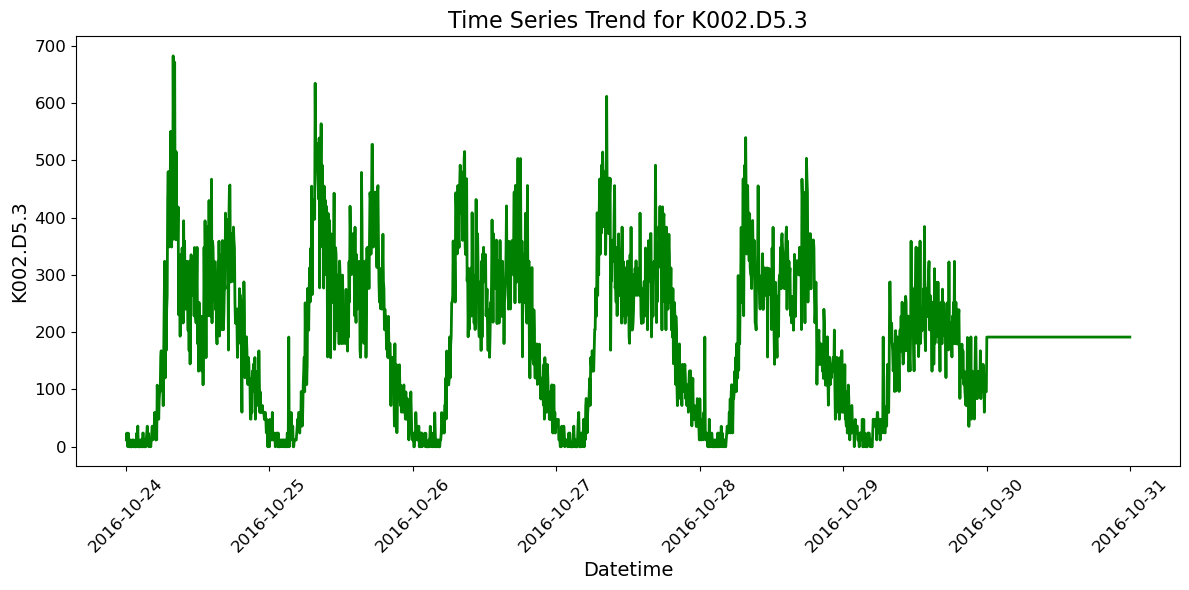

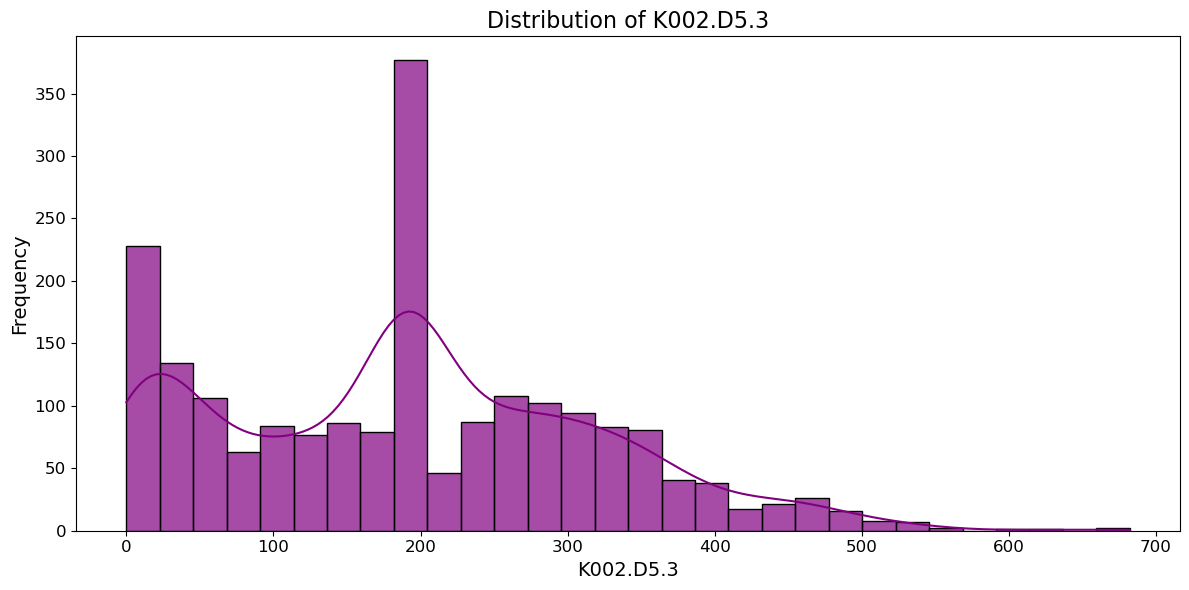

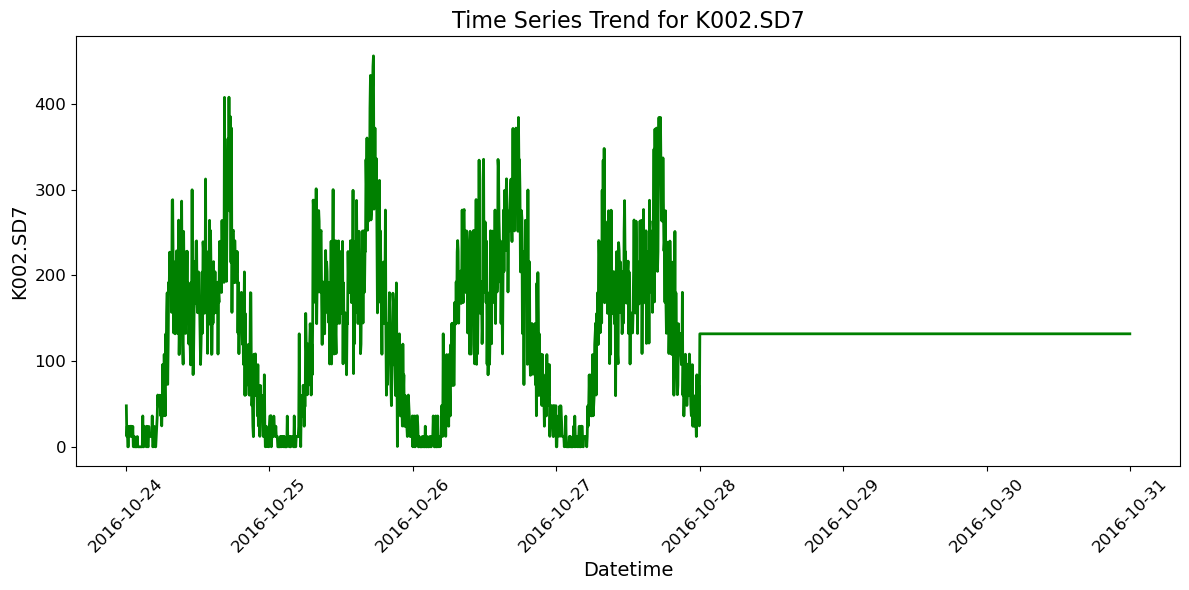

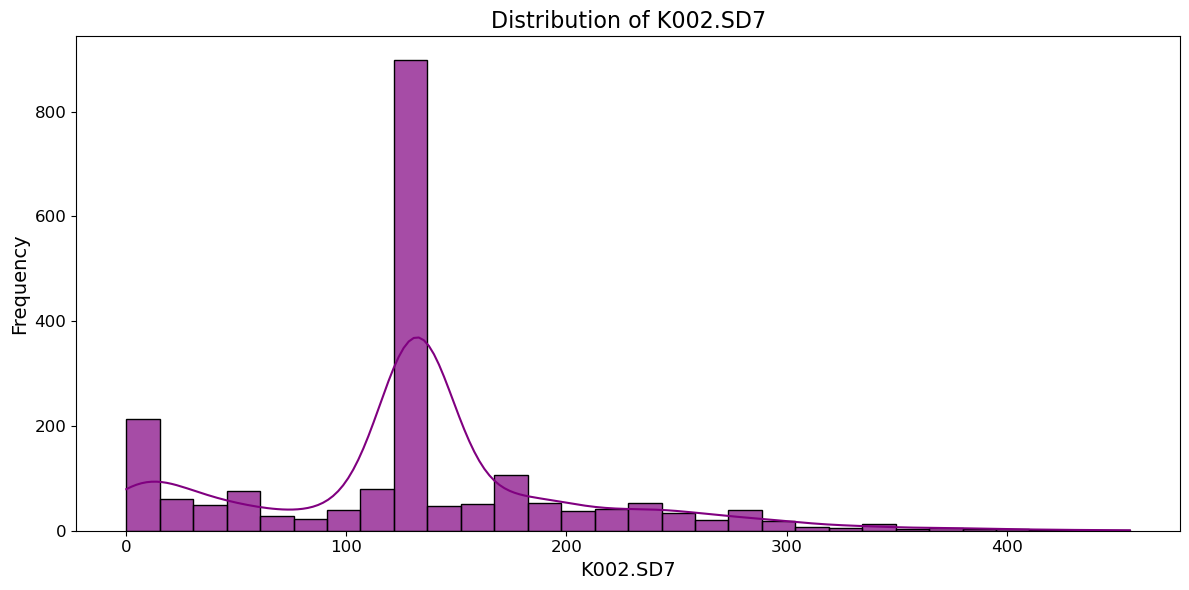

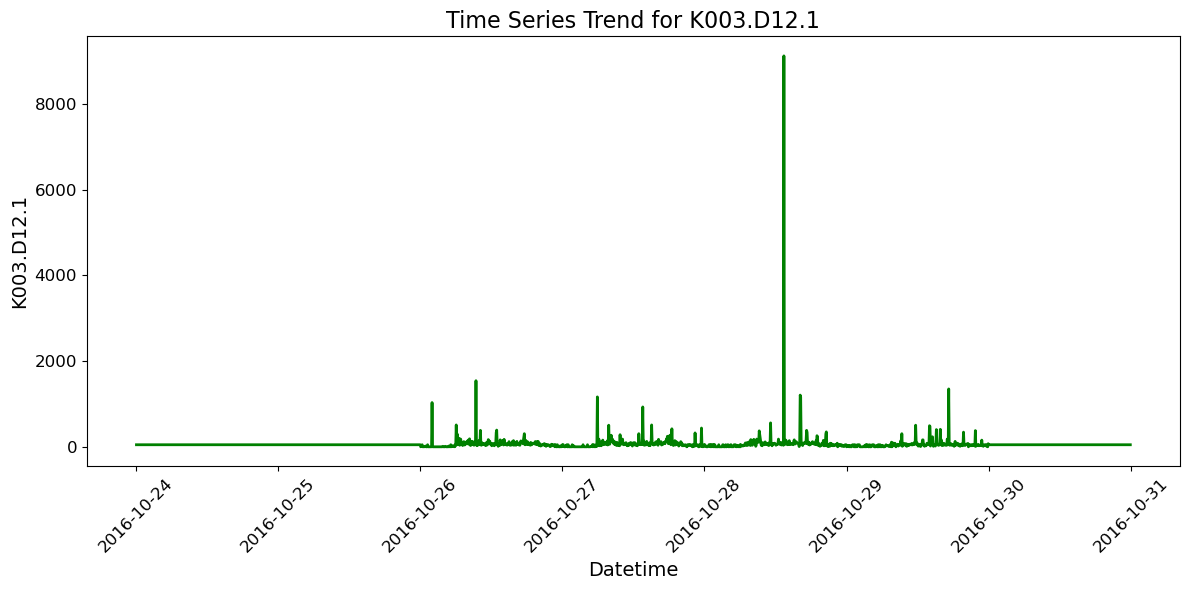

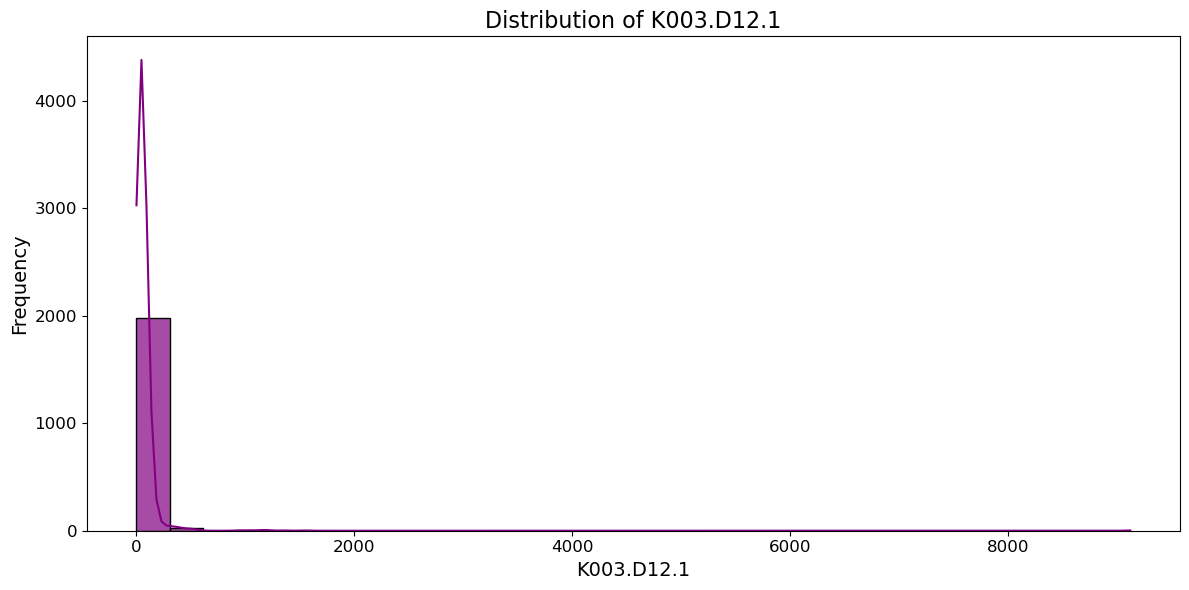

In [18]:
# Ensure datetime in bern_uniform_df is in proper format
bern_uniform_df['datetime'] = pd.to_datetime(bern_uniform_df['datetime'], errors='coerce')

# Loop through columns in the dataframe
for col in df.columns:
    plt.figure(figsize=(12, 6))
    
    # Categorical Columns
    if col in [ 'fclass', 'road', 'citycode']:
        sns.countplot(y=col, data=df, order=df[col].value_counts().index[:20], palette="viridis")
        plt.title(f'Distribution of Top  {col}', fontsize=16)
        plt.ylabel(col, fontsize=14)
        plt.xlabel('Count', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
    
    # Numerical Columns
    elif col in ['length', 'pos', 'limit', 'lanes', 'linkid']:
        sns.histplot(df[col], kde=True, bins=30, color="blue", alpha=0.7)
        plt.title(f'Distribution of {col}', fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
    
#     # Geographical Columns
#     elif col in ['long', 'lat']:
#         if 'long' in df.columns and 'lat' in df.columns:
#             plt.figure(figsize=(10, 6))
#             plt.scatter(df['long'], df['lat'], c="red", alpha=0.6, label="Detectors")
#             plt.title('Geographical Scatter Plot', fontsize=16)
#             plt.xlabel('Longitude', fontsize=14)
#             plt.ylabel('Latitude', fontsize=14)
#             plt.xticks(fontsize=12)
#             plt.yticks(fontsize=12)
#             plt.legend(fontsize=12)
#         else:
#             print(f"Skipping {col} as its counterpart column is missing.")
    
    plt.tight_layout()
    plt.show()

# Time Series and Distribution Plot for Selected Columns (Second Dataset)
sample_cols = bern_uniform_df.columns[1:10]  # Adjust range based on actual data

for col in sample_cols:
    if col != 'datetime':  # Skip 'datetime' for these plots
        # Time Series Line Plot
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='datetime', y=col, data=bern_uniform_df, color="green", linewidth=2)
        plt.title(f'Time Series Trend for {col}', fontsize=16)
        plt.xlabel('Datetime', fontsize=14)
        plt.ylabel(col, fontsize=14)
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()

        # Distribution Plot
        plt.figure(figsize=(12, 6))
        sns.histplot(bern_uniform_df[col], kde=True, bins=30, color="purple", alpha=0.7)
        plt.title(f'Distribution of {col}', fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()


#  Trend for  detid

In [20]:
# List of the detid values you want to filter
detid_values = ['K001.D6.4', 'K001.D6.5', 'K001.D6.6', 'K02.D5.3', 'K002.SD7', 'K003.D12.1']

# Filter the DataFrame for these values in the 'detid' column
filtered_df = df[df['detid'].isin(detid_values)]

# Display the filtered rows
filtered_df['fclass'].unique()


array(['residential', 'primary'], dtype=object)

In [21]:
df

detid    length       pos       fclass                  road  limit  \
0     K123.D4.2  0.446927  0.028676     tertiary       Morillonstrasse     50   
1     K024.D4.3  0.072176  0.001133    secondary         Hodlerstrasse     50   
2     K123.D1.2  0.223026  0.012866     tertiary       Morillonstrasse     50   
3     K123.D1.1  0.223026  0.000000     tertiary       Morillonstrasse     50   
4     K078.D2.4  0.418011  0.108193    secondary  Ostermundigenstrasse     50   
..          ...       ...       ...          ...                   ...    ...   
750   K140.D9.1  0.294524  0.002922      primary        Schlossstrasse     50   
751  K140.D11.1  0.106510  0.002453      primary        Schlossstrasse     50   
752   K123.D5.3  0.165917  0.026257    secondary       Seftigenstrasse     50   
753   K123.D5.0  0.124732  0.123497    secondary       Seftigenstrasse     50   
754  K140.D11.2  0.106510  0.023425  residential      Friedbühlstrasse     30   

    citycode  lanes  linkid      long        lat  location_cluster  \
0       bern    1.0   227.0  7.435123  46.934680                 7   
1       bern    1.0    18.0  7.442159  46.951922                 5   
2       bern    1.0   228.0  7.435482  46.935309                 7   
3       bern    1.0   228.0  7.435434  46.935196                 7   
4       bern    1.0   170.0  7.463267  46.952259                 5   
..       ...    ...     ...       ...        ...               ...   
750     bern    1.0   312.0  7.420068  46.944487                 2   
751     bern    1.0   314.0  7.420256  46.944594                 2   
752     bern    1.0   230.0  7.434875  46.935148                 5   
753     bern    1.0   223.0  7.435204  46.935044                 5   
754     bern    1.0   314.0  7.420524  46.944632                 4   

     distance_to_center  
0              1.761230  
1              0.585708  
2              1.687586  
3              1.700112  
4              1.290907  
..                  ...  
750            2.122069  
751            2.105775  
752            1.727776  
753            1.723750  
754            2.084929  

[755 rows x 13 columns]

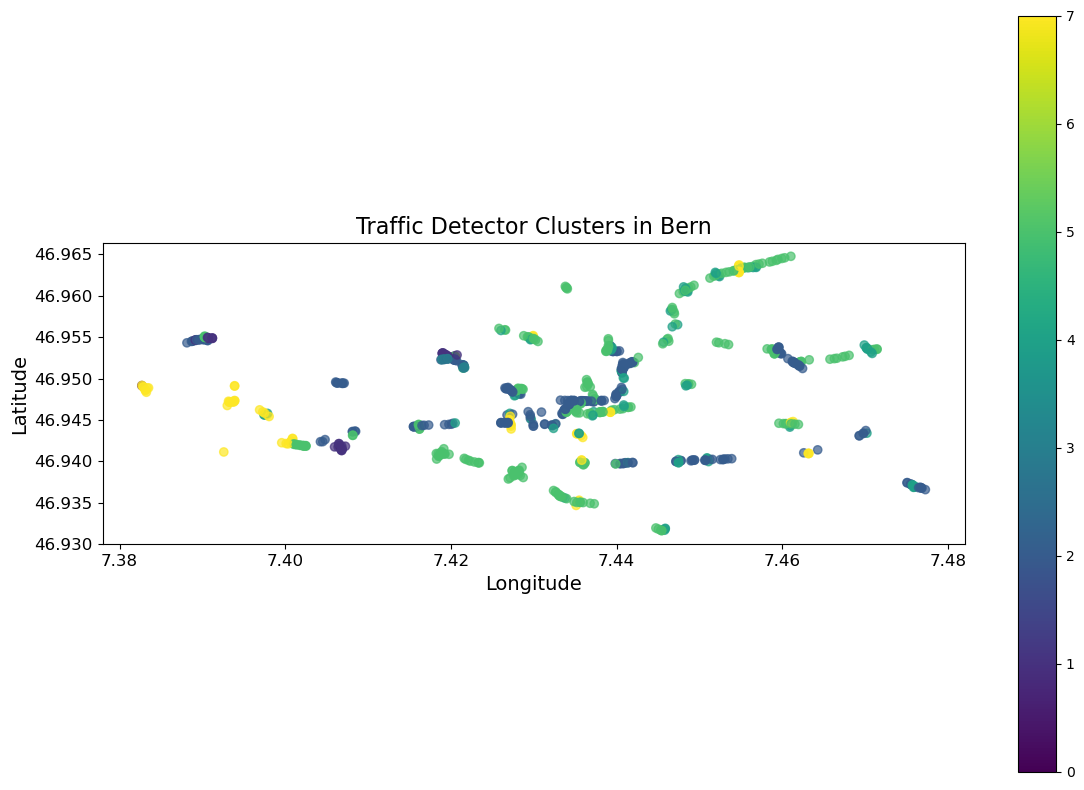

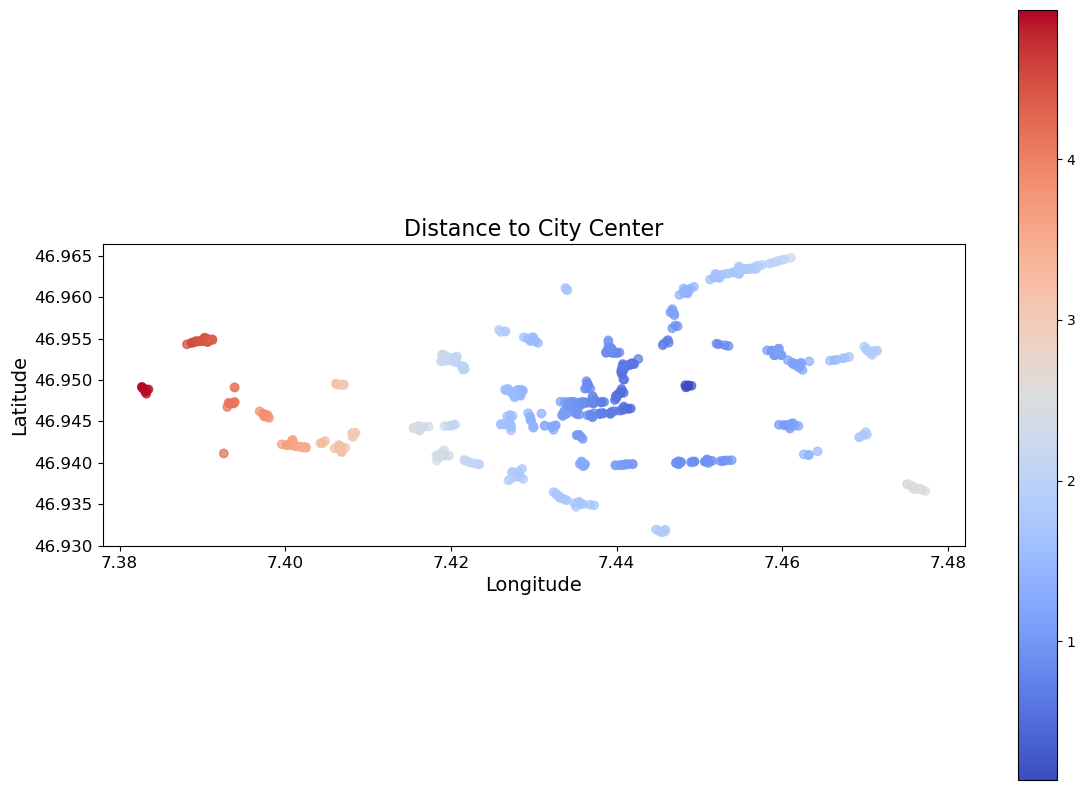

In [22]:
# Ensure the required columns exist
if 'long' in df.columns and 'lat' in df.columns:
    # Create a GeoDataFrame for visualization
    geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)

    # Plot clusters on a map
    if 'location_cluster' in gdf.columns:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        gdf.plot(column='location_cluster', legend=True, ax=ax, cmap='viridis', alpha=0.7)
        ax.set_title('Traffic Detector Clusters in Bern', fontsize=16)
        ax.set_xlabel('Longitude', fontsize=14)
        ax.set_ylabel('Latitude', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()
    else:
        print("Column 'location_cluster' not found in DataFrame.")

    # Plot distance from the city center on another map
    if 'distance_to_center' in gdf.columns:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        gdf.plot(column='distance_to_center', legend=True, ax=ax, cmap='coolwarm', alpha=0.7)
        ax.set_title('Distance to City Center', fontsize=16)
        ax.set_xlabel('Longitude', fontsize=14)
        ax.set_ylabel('Latitude', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()
    else:
        print("Column 'distance_to_center' not found in DataFrame.")
else:
    print("Columns 'long' and 'lat' are required to create a GeoDataFrame.")


In [23]:
# # Define a reference point (latitude, longitude) for Bern city center
# bern_city_center = (46.94809, 7.44744)  # Latitude, Longitude

# # Haversine formula to calculate distance
# def haversine(lat1, lon1, lat2, lon2):
#     R = 6371  # Earth radius in kilometers
#     phi1, phi2 = np.radians(lat1), np.radians(lat2)
#     dphi = np.radians(lat2 - lat1)
#     dlambda = np.radians(lon2 - lon1)
#     a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
#     return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# # Calculate distances from the city center
# df['distance_to_center'] = df.apply(
#     lambda row: haversine(row['lat'], row['long'], bern_city_center[0], bern_city_center[1]),
#     axis=1
# )

# # Display the updated DataFrame with distances
# print("DataFrame with Distance to City Center:")
# print(df[['detid', 'lat', 'long', 'distance_to_center']].head())

# # Apply K-Means clustering
# kmeans = KMeans(n_clusters=5, random_state=42)  # Choose 5 clusters (tune as needed)
# df['location_cluster'] = kmeans.fit_predict(df[['lat', 'long']])

# # Display the clusters
# print("\nDataFrame with Location Clusters:")
# print(df[['detid', 'lat', 'long', 'location_cluster']].head())

# # Optional: Analyze cluster sizes
# cluster_counts = df['location_cluster'].value_counts()
# print("\nCluster Sizes:")
# print(cluster_counts)

In [24]:
df

detid    length       pos       fclass                  road  limit  \
0     K123.D4.2  0.446927  0.028676     tertiary       Morillonstrasse     50   
1     K024.D4.3  0.072176  0.001133    secondary         Hodlerstrasse     50   
2     K123.D1.2  0.223026  0.012866     tertiary       Morillonstrasse     50   
3     K123.D1.1  0.223026  0.000000     tertiary       Morillonstrasse     50   
4     K078.D2.4  0.418011  0.108193    secondary  Ostermundigenstrasse     50   
..          ...       ...       ...          ...                   ...    ...   
750   K140.D9.1  0.294524  0.002922      primary        Schlossstrasse     50   
751  K140.D11.1  0.106510  0.002453      primary        Schlossstrasse     50   
752   K123.D5.3  0.165917  0.026257    secondary       Seftigenstrasse     50   
753   K123.D5.0  0.124732  0.123497    secondary       Seftigenstrasse     50   
754  K140.D11.2  0.106510  0.023425  residential      Friedbühlstrasse     30   

    citycode  lanes  linkid      long        lat  location_cluster  \
0       bern    1.0   227.0  7.435123  46.934680                 7   
1       bern    1.0    18.0  7.442159  46.951922                 5   
2       bern    1.0   228.0  7.435482  46.935309                 7   
3       bern    1.0   228.0  7.435434  46.935196                 7   
4       bern    1.0   170.0  7.463267  46.952259                 5   
..       ...    ...     ...       ...        ...               ...   
750     bern    1.0   312.0  7.420068  46.944487                 2   
751     bern    1.0   314.0  7.420256  46.944594                 2   
752     bern    1.0   230.0  7.434875  46.935148                 5   
753     bern    1.0   223.0  7.435204  46.935044                 5   
754     bern    1.0   314.0  7.420524  46.944632                 4   

     distance_to_center  
0              1.761230  
1              0.585708  
2              1.687586  
3              1.700112  
4              1.290907  
..                  ...  
750            2.122069  
751            2.105775  
752            1.727776  
753            1.723750  
754            2.084929  

[755 rows x 13 columns]

In [30]:

# Define a base map centered around Bern
bern_center = [46.94809, 7.44744]  # Latitude and Longitude of Bern city center
m = folium.Map(location=bern_center, zoom_start=12)

# Add Marker Clusters for the detectors
marker_cluster = MarkerCluster().add_to(m)

# Add points to the map with additional information
for idx, row in df.iterrows():
    # Construct the popup information
    popup_info = f"""
    <b>Detector ID:</b> {row['detid']}<br>
    <b>Cluster:</b> {row['location_cluster']}<br>
    <b>Road:</b> {row['road']}<br>
    <b>Road Type:</b> {row['fclass']}<br>
    <b>Speed Limit:</b> {row['limit']} km/h<br>
    <b>Distance to Center:</b> {row['distance_to_center']:.2f} km
    """
    
    # Add a marker for each detector
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=popup_info,
        icon=folium.Icon(color='blue' if row['location_cluster'] % 2 == 0 else 'green')
    ).add_to(marker_cluster)

# Add a marker for Bern city center
folium.Marker(
    location=bern_center,
    popup="<b>Bern City Center</b>",
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(m)

# Display the map in the Jupyter Notebook
display(m)


In [31]:
# Define a base map centered around Bern
bern_center = [46.94809, 7.44744]  # Latitude and Longitude of Bern city center
m = folium.Map(location=bern_center, zoom_start=12)

# Add Marker Clusters for the detectors
marker_cluster = MarkerCluster().add_to(m)

# Add points to the map with additional information
for idx, row in df.iterrows():
    popup_info = f"""
    Detector ID: {row['detid']}<br>
    Cluster: {row['location_cluster']}<br>
    Road: {row['road']}<br>
    Road Type: {row['fclass']}<br>
    Speed Limit: {row['limit']} km/h<br>
    Distance to Center: {row['distance_to_center']:.2f} km
    """
    
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=popup_info,
        icon=folium.Icon(color='blue' if row['location_cluster'] % 2 == 0 else 'green')
    ).add_to(marker_cluster)

# Create a heatmap layer using latitudes, longitudes, and some traffic-related value (if available)
heat_data = [[row['lat'], row['long'], row['distance_to_center']] for idx, row in df.iterrows()]
HeatMap(heat_data).add_to(m)

# Add a marker for Bern city center
folium.Marker(
    location=bern_center,
    popup="Bern City Center",
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(m)

# Display the map in the Jupyter Notebook
display(m)


In [33]:
df

detid    length       pos       fclass                  road  limit  \
0     K123.D4.2  0.446927  0.028676     tertiary       Morillonstrasse     50   
1     K024.D4.3  0.072176  0.001133    secondary         Hodlerstrasse     50   
2     K123.D1.2  0.223026  0.012866     tertiary       Morillonstrasse     50   
3     K123.D1.1  0.223026  0.000000     tertiary       Morillonstrasse     50   
4     K078.D2.4  0.418011  0.108193    secondary  Ostermundigenstrasse     50   
..          ...       ...       ...          ...                   ...    ...   
750   K140.D9.1  0.294524  0.002922      primary        Schlossstrasse     50   
751  K140.D11.1  0.106510  0.002453      primary        Schlossstrasse     50   
752   K123.D5.3  0.165917  0.026257    secondary       Seftigenstrasse     50   
753   K123.D5.0  0.124732  0.123497    secondary       Seftigenstrasse     50   
754  K140.D11.2  0.106510  0.023425  residential      Friedbühlstrasse     30   

    citycode  lanes  linkid      long        lat  location_cluster  \
0       bern    1.0   227.0  7.435123  46.934680                 7   
1       bern    1.0    18.0  7.442159  46.951922                 5   
2       bern    1.0   228.0  7.435482  46.935309                 7   
3       bern    1.0   228.0  7.435434  46.935196                 7   
4       bern    1.0   170.0  7.463267  46.952259                 5   
..       ...    ...     ...       ...        ...               ...   
750     bern    1.0   312.0  7.420068  46.944487                 2   
751     bern    1.0   314.0  7.420256  46.944594                 2   
752     bern    1.0   230.0  7.434875  46.935148                 5   
753     bern    1.0   223.0  7.435204  46.935044                 5   
754     bern    1.0   314.0  7.420524  46.944632                 4   

     distance_to_center  
0              1.761230  
1              0.585708  
2              1.687586  
3              1.700112  
4              1.290907  
..                  ...  
750            2.122069  
751            2.105775  
752            1.727776  
753            1.723750  
754            2.084929  

[755 rows x 13 columns]

In [34]:
# Drop rows with null values in any column
df = df.dropna().reset_index(drop=True)

# Optional: Verify there are no nulls left and print the updated DataFrame info
print(f"Null values in df after drop: {df.isna().sum().sum()}")
print(df.info())


Null values in df after drop: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   detid               755 non-null    object 
 1   length              755 non-null    float64
 2   pos                 755 non-null    float64
 3   fclass              755 non-null    object 
 4   road                755 non-null    object 
 5   limit               755 non-null    int64  
 6   citycode            755 non-null    object 
 7   lanes               755 non-null    float64
 8   linkid              755 non-null    float64
 9   long                755 non-null    float64
 10  lat                 755 non-null    float64
 11  location_cluster    755 non-null    int8   
 12  distance_to_center  755 non-null    float64
dtypes: float64(7), int64(1), int8(1), object(4)
memory usage: 71.6+ KB
None


In [35]:
print(bern_uniform_df.columns)  # Check all columns in bern_uniform_df


Index(['datetime', 'K001.D6.1', 'K001.D6.2', 'K001.D6.3', 'K001.D6.4',
       'K001.D6.5', 'K001.D6.6', 'K002.D5.3', 'K002.SD7', 'K003.D12.1',
       ...
       'K163.D6.21', 'K163.D9.20', 'K163.D9.21', 'K165.D2.1', 'K165.D2.2',
       'K165.D2.3', 'K165.D4.1', 'K165.D4.2', 'K169.D4.2', 'K171.SD5'],
      dtype='object', length=431)


In [36]:
# Step 1: Ensure 'datetime' in `bern_uniform_df` is in datetime format
bern_uniform_df['datetime'] = pd.to_datetime(bern_uniform_df['datetime'], errors='coerce')

# Step 2: Reshape `bern_uniform_df` to long format, keeping only datetime and traffic flow columns
traffic_flow_long = bern_uniform_df.melt(
    id_vars=['datetime'],  # Keep the 'datetime' column
    var_name='detid',      # Create a column for detector IDs
    value_name='traffic_flow'  # Create a column for traffic flow values
)

# Step 3: Check the reshaped data to ensure it's correct
print(traffic_flow_long.head())

# Step 4: Merge the reshaped traffic flow data with the existing df
df = pd.merge(
    df, 
    traffic_flow_long,  # Merge with reshaped data
    on='detid',         # Merge on 'detid'
    how='left'          # Left join to keep all rows from df
)

# Step 5: Handle missing values in 'traffic_flow' by filling with the median
if df['traffic_flow'].isnull().any():
    median_traffic_flow = df['traffic_flow'].median()  # Compute median once
    df['traffic_flow'] = df['traffic_flow'].fillna(median_traffic_flow)  # Fill NaN values

# Step 6: Drop rows with missing values in 'traffic_flow' column
df = df.dropna(subset=['traffic_flow'])

# Step 7: Reset the index after dropping rows
df = df.reset_index(drop=True)

# Check the result
print(df.head())


             datetime      detid  traffic_flow
0 2016-10-24 00:05:00  K001.D6.1           0.0
1 2016-10-24 00:10:00  K001.D6.1          12.0
2 2016-10-24 00:15:00  K001.D6.1         121.1
3 2016-10-24 00:20:00  K001.D6.1          24.0
4 2016-10-24 00:25:00  K001.D6.1          12.0
       detid    length       pos    fclass             road  limit citycode  \
0  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   
1  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   
2  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   
3  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   
4  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   

   lanes  linkid      long       lat  location_cluster  distance_to_center  \
0    1.0   227.0  7.435123  46.93468                 7             1.76123   
1    1.0   227.0  7.435123  46.93468                 7             1.76123   
2    1.0 

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866775 entries, 0 to 866774
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   detid               866775 non-null  object        
 1   length              866775 non-null  float64       
 2   pos                 866775 non-null  float64       
 3   fclass              866775 non-null  object        
 4   road                866775 non-null  object        
 5   limit               866775 non-null  int64         
 6   citycode            866775 non-null  object        
 7   lanes               866775 non-null  float64       
 8   linkid              866775 non-null  float64       
 9   long                866775 non-null  float64       
 10  lat                 866775 non-null  float64       
 11  location_cluster    866775 non-null  int8          
 12  distance_to_center  866775 non-null  float64       
 13  datetime            866450 no

In [38]:
# Drop the unnecessary columns
#df = df.drop(columns=['datetime'])

# Verify the remaining columns
#print(df.head())
#

In [154]:

# Define a base map centered around Bern
bern_center = [46.94809, 7.44744]  # Latitude and Longitude of Bern city center
m = folium.Map(location=bern_center, zoom_start=12)

# Add Marker Clusters for the detectors
marker_cluster = MarkerCluster().add_to(m)

# Define a function for color coding based on traffic flow
def get_color(traffic_flow):
    if traffic_flow < 30:
        return 'green'
    elif traffic_flow < 70:
        return 'orange'
    else:
        return 'red'

# Add points to the map with traffic flow information
for idx, row in df.iterrows():
    popup_info = f"""
    Detector ID: {row['detid']}<br>
    Cluster: {row['location_cluster']}<br>
    Distance to Center: {row['distance_to_center']:.2f} km<br>
    Current Traffic Flow: {row['traffic_flow']} vehicles/hour
    """
    
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=popup_info,
        icon=folium.Icon(color=get_color(row['traffic_flow']))
    ).add_to(marker_cluster)

# Display the map in the Jupyter Notebook
display(m)


KeyboardInterrupt: 

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866775 entries, 0 to 866774
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   detid               866775 non-null  object        
 1   length              866775 non-null  float64       
 2   pos                 866775 non-null  float64       
 3   fclass              866775 non-null  object        
 4   road                866775 non-null  object        
 5   limit               866775 non-null  int64         
 6   citycode            866775 non-null  object        
 7   lanes               866775 non-null  float64       
 8   linkid              866775 non-null  float64       
 9   long                866775 non-null  float64       
 10  lat                 866775 non-null  float64       
 11  location_cluster    866775 non-null  int8          
 12  distance_to_center  866775 non-null  float64       
 13  datetime            866450 no

In [ ]:
# # Assuming 'df' is your dataset (replace with your actual dataset)
# # Adding the 'incident' column to your dataset based on some criteria
# # Just for generating random incidents as examples

# incident_options = ['Accident', 'Roadwork', 'Traffic Jam', 'Construction']

# # Create a random 'incident' column (replace with your own logic or data)
# df['incident'] = [random.choice(incident_options) for _ in range(len(df))]  # Example, replace with actual logic

# # Now, you have a new 'incident' column in your dataframe
# # Let's assume 'severity' is another column you have in your dataset
# # You can generate severity dynamically, or use a pre-defined rule
# df['severity'] = ['High' if incident == 'Accident' else 'Medium' if incident in ['Roadwork', 'Construction'] else 'Low' for incident in df['incident']]

# # Example of how to check your dataframe now
# print(df[['detid', 'lat', 'long', 'incident', 'severity']].head())

# # Define a base map centered around Bern
# bern_center = [46.94809, 7.44744]  # Latitude and Longitude of Bern city center
# m = folium.Map(location=bern_center, zoom_start=12)

# # Add Marker Clusters for the detectors
# marker_cluster = MarkerCluster().add_to(m)

# # Add markers based on the incident column
# for idx, row in df.iterrows():
#     folium.Marker(
#         location=[row['lat'], row['long']],
#         popup=f"Detector ID: {row['detid']}<br>Incident: {row['incident']}<br>Severity: {row['severity']}",
#         icon=folium.Icon(color='red' if row['severity'] == 'High' else 'orange' if row['severity'] == 'Medium' else 'green')
#     ).add_to(marker_cluster)

# # Display the map in the Jupyter Notebook
# display(m)

# # Optional: Save the map with incident markers (if you need to save it as well)
# map_file_with_incidents = 'bern_traffic_incidents.html'
# m.save(map_file_with_incidents)
# print(f"The interactive map with incidents has been saved as {map_file_with_incidents}.")


# feature engineering 

In [59]:

# Step 1: Calculate the median and standard deviation of traffic flow for each 'detid'
traffic_flow_stats = df.groupby('detid')['traffic_flow'].agg(['median', 'std']).reset_index()
traffic_flow_stats.rename(columns={'median': 'traffic_flow_median', 'std': 'traffic_flow_std'}, inplace=True)

# Step 2: Merge traffic flow statistics back to the main dataframe
df = pd.merge(df, traffic_flow_stats, on='detid', how='left')

# Step 3: Define a threshold for identifying incidents (2 standard deviations)
threshold_upper = df['traffic_flow_median'] + 2 * df['traffic_flow_std']
threshold_lower = df['traffic_flow_median'] - 2 * df['traffic_flow_std']

# Step 4: Create the 'incident' column
df['incident'] = ((df['traffic_flow'] > threshold_upper) | (df['traffic_flow'] < threshold_lower))

# Step 5: Verify the resulting dataframe
print(df[['datetime', 'detid', 'traffic_flow', 'incident']].head())


             datetime      detid  traffic_flow  incident
0 2016-10-24 00:05:00  K123.D4.2          24.0     False
1 2016-10-24 00:10:00  K123.D4.2          36.0     False
2 2016-10-24 00:15:00  K123.D4.2           0.0     False
3 2016-10-24 00:20:00  K123.D4.2         145.2     False
4 2016-10-24 00:25:00  K123.D4.2          24.4     False


In [61]:
# Step 1: Define conditions based on traffic flow (customize these thresholds as needed)
conditions = [
    (df['traffic_flow'] > 1000),  # Traffic flow significantly high
    (df['traffic_flow'] > 500) & (df['traffic_flow'] <= 1000),  # Moderate high flow
    (df['traffic_flow'] > 150) & (df['traffic_flow'] <= 500),  # Medium traffic flow
    (df['traffic_flow'] <= 150)  # Low traffic flow
]

# Step 2: Define incident types for each condition
incident_types = ['Accident', 'Roadwork', 'Traffic Jam', 'Construction']

# Step 3: Apply the conditions to assign the corresponding incident types
df['incident'] = 'No Incident'  # Default value if no incident is detected

# Apply the conditions to populate the 'incident' column
for condition, incident_type in zip(conditions, incident_types):
    df.loc[condition, 'incident'] = incident_type

# Step 4: Verify the result
print(df[['datetime', 'detid', 'traffic_flow', 'incident']].head())


             datetime      detid  traffic_flow      incident
0 2016-10-24 00:05:00  K123.D4.2          24.0  Construction
1 2016-10-24 00:10:00  K123.D4.2          36.0  Construction
2 2016-10-24 00:15:00  K123.D4.2           0.0  Construction
3 2016-10-24 00:20:00  K123.D4.2         145.2  Construction
4 2016-10-24 00:25:00  K123.D4.2          24.4  Construction


In [63]:
# Generate severity based on incident
df['severity'] = ['High' if incident == 'Accident' else 'Medium' if incident in ['Roadwork', 'Construction'] else 'Low' for incident in df['incident']]

# Assign numerical weights based on severity
severity_weights = {'High': 3, 'Medium': 2, 'Low': 1}
df['severity_weight'] = df['severity'].map(severity_weights)


In [65]:
df.columns

Index(['detid', 'length', 'pos', 'fclass', 'road', 'limit', 'citycode',
       'lanes', 'linkid', 'long', 'lat', 'location_cluster',
       'distance_to_center', 'datetime', 'traffic_flow', 'traffic_flow_median',
       'traffic_flow_std', 'incident', 'severity', 'severity_weight'],
      dtype='object')

In [ ]:

# Define a base map centered around Bern
bern_center = [46.94809, 7.44744]  # Latitude and Longitude of Bern city center
m = folium.Map(location=bern_center, zoom_start=12)

# Create the heatmap data
heat_data = [[row['lat'], row['long'], row['severity_weight']] for _, row in df.iterrows()]

# Add the heatmap layer
HeatMap(heat_data).add_to(m)

# Add Marker Clusters for the detectors
marker_cluster = MarkerCluster().add_to(m)

# Add markers with incident information based on severity
for idx, row in df.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=f"Detector ID: {row['detid']}<br>Incident: {row['incident']}<br>Severity: {row['severity']}",
        icon=folium.Icon(color='red' if row['severity'] == 'High' else 'orange' if row['severity'] == 'Medium' else 'green')
    ).add_to(marker_cluster)

# Display the map in the Jupyter Notebook
m



In [67]:
# Get unique values
print("Unique values in 'incident' column:")
print(df['incident'].unique())

# Get the counts of unique values
print("\nValue counts for 'incident' column:")
print(df['incident'].value_counts())


Unique values in 'incident' column:
['Construction' 'Traffic Jam' 'Roadwork' 'Accident']

Value counts for 'incident' column:
incident
Traffic Jam     446624
Construction    381076
Roadwork         38129
Accident           946
Name: count, dtype: int64


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866775 entries, 0 to 866774
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   detid                866775 non-null  object        
 1   length               866775 non-null  float64       
 2   pos                  866775 non-null  float64       
 3   fclass               866775 non-null  object        
 4   road                 866775 non-null  object        
 5   limit                866775 non-null  int64         
 6   citycode             866775 non-null  object        
 7   lanes                866775 non-null  float64       
 8   linkid               866775 non-null  float64       
 9   long                 866775 non-null  float64       
 10  lat                  866775 non-null  float64       
 11  location_cluster     866775 non-null  int8          
 12  distance_to_center   866775 non-null  float64       
 13  datetime      

In [71]:
import gc  # Import the garbage collection module
# Force garbage collection to clear unreferenced objects
gc.collect()


0

In [73]:
df

detid    length       pos       fclass              road  limit  \
0        K123.D4.2  0.446927  0.028676     tertiary   Morillonstrasse     50   
1        K123.D4.2  0.446927  0.028676     tertiary   Morillonstrasse     50   
2        K123.D4.2  0.446927  0.028676     tertiary   Morillonstrasse     50   
3        K123.D4.2  0.446927  0.028676     tertiary   Morillonstrasse     50   
4        K123.D4.2  0.446927  0.028676     tertiary   Morillonstrasse     50   
...            ...       ...       ...          ...               ...    ...   
866770  K140.D11.2  0.106510  0.023425  residential  Friedbühlstrasse     30   
866771  K140.D11.2  0.106510  0.023425  residential  Friedbühlstrasse     30   
866772  K140.D11.2  0.106510  0.023425  residential  Friedbühlstrasse     30   
866773  K140.D11.2  0.106510  0.023425  residential  Friedbühlstrasse     30   
866774  K140.D11.2  0.106510  0.023425  residential  Friedbühlstrasse     30   

       citycode  lanes  linkid      long        lat  location_cluster  \
0          bern    1.0   227.0  7.435123  46.934680                 7   
1          bern    1.0   227.0  7.435123  46.934680                 7   
2          bern    1.0   227.0  7.435123  46.934680                 7   
3          bern    1.0   227.0  7.435123  46.934680                 7   
4          bern    1.0   227.0  7.435123  46.934680                 7   
...         ...    ...     ...       ...        ...               ...   
866770     bern    1.0   314.0  7.420524  46.944632                 4   
866771     bern    1.0   314.0  7.420524  46.944632                 4   
866772     bern    1.0   314.0  7.420524  46.944632                 4   
866773     bern    1.0   314.0  7.420524  46.944632                 4   
866774     bern    1.0   314.0  7.420524  46.944632                 4   

        distance_to_center            datetime  traffic_flow  \
0                 1.761230 2016-10-24 00:05:00          24.0   
1                 1.761230 2016-10-24 00:10:00          36.0   
2                 1.761230 2016-10-24 00:15:00           0.0   
3                 1.761230 2016-10-24 00:20:00         145.2   
4                 1.761230 2016-10-24 00:25:00          24.4   
...                    ...                 ...           ...   
866770            2.084929 2016-10-30 23:35:00         144.7   
866771            2.084929 2016-10-30 23:40:00         144.7   
866772            2.084929 2016-10-30 23:45:00         144.7   
866773            2.084929 2016-10-30 23:50:00         144.7   
866774            2.084929 2016-10-30 23:55:00         144.7   

        traffic_flow_median  traffic_flow_std      incident severity  \
0                     145.2         93.722005  Construction   Medium   
1                     145.2         93.722005  Construction   Medium   
2                     145.2         93.722005  Construction   Medium   
3                     145.2         93.722005  Construction   Medium   
4                     145.2         93.722005  Construction   Medium   
...                     ...               ...           ...      ...   
866770                144.7        115.520354  Construction   Medium   
866771                144.7        115.520354  Construction   Medium   
866772                144.7        115.520354  Construction   Medium   
866773                144.7        115.520354  Construction   Medium   
866774                144.7        115.520354  Construction   Medium   

        severity_weight  
0                     2  
1                     2  
2                     2  
3                     2  
4                     2  
...                 ...  
866770                2  
866771                2  
866772                2  
866773                2  
866774                2  

[866775 rows x 20 columns]

In [75]:

# Step 1: Calculate the mean traffic flow for each detid and assign it to a new column avg_traffic_flow
df['avg_traffic_flow'] = df.groupby('detid')['traffic_flow'].transform('mean')

# Step 2: Create the severity_weighted_traffic feature by multiplying avg_traffic_flow by severity_weight
df['severity_weighted_traffic'] = df['avg_traffic_flow'] * df['severity_weight']


In [77]:
df.head()

detid    length       pos    fclass             road  limit citycode  \
0  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   
1  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   
2  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   
3  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   
4  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   

   lanes  linkid      long  ...  distance_to_center            datetime  \
0    1.0   227.0  7.435123  ...             1.76123 2016-10-24 00:05:00   
1    1.0   227.0  7.435123  ...             1.76123 2016-10-24 00:10:00   
2    1.0   227.0  7.435123  ...             1.76123 2016-10-24 00:15:00   
3    1.0   227.0  7.435123  ...             1.76123 2016-10-24 00:20:00   
4    1.0   227.0  7.435123  ...             1.76123 2016-10-24 00:25:00   

   traffic_flow traffic_flow_median  traffic_flow_std      incident  severity  \
0          24.0               145.2         93.722005  Construction    Medium   
1          36.0               145.2         93.722005  Construction    Medium   
2           0.0               145.2         93.722005  Construction    Medium   
3         145.2               145.2         93.722005  Construction    Medium   
4          24.4               145.2         93.722005  Construction    Medium   

  severity_weight avg_traffic_flow  severity_weighted_traffic  
0               2       148.835753                 297.671506  
1               2       148.835753                 297.671506  
2               2       148.835753                 297.671506  
3               2       148.835753                 297.671506  
4               2       148.835753                 297.671506  

[5 rows x 22 columns]

In [79]:
df.columns 

Index(['detid', 'length', 'pos', 'fclass', 'road', 'limit', 'citycode',
       'lanes', 'linkid', 'long', 'lat', 'location_cluster',
       'distance_to_center', 'datetime', 'traffic_flow', 'traffic_flow_median',
       'traffic_flow_std', 'incident', 'severity', 'severity_weight',
       'avg_traffic_flow', 'severity_weighted_traffic'],
      dtype='object')

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866775 entries, 0 to 866774
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   detid                      866775 non-null  object        
 1   length                     866775 non-null  float64       
 2   pos                        866775 non-null  float64       
 3   fclass                     866775 non-null  object        
 4   road                       866775 non-null  object        
 5   limit                      866775 non-null  int64         
 6   citycode                   866775 non-null  object        
 7   lanes                      866775 non-null  float64       
 8   linkid                     866775 non-null  float64       
 9   long                       866775 non-null  float64       
 10  lat                        866775 non-null  float64       
 11  location_cluster           866775 non-null  int8    

- Rolling Statistics: Calculate rolling mean, standard deviation, or sum for traffic_flow over different time windows to capture short-term trends.

In [83]:
df['rolling_mean_traffic'] = df['traffic_flow'].rolling(window=3, min_periods=1).mean()
df['rolling_std_traffic'] = df['traffic_flow'].rolling(window=3, min_periods=1).std()


- Lag Features: Add lagged versions of traffic_flow to predict future values

In [86]:
df['traffic_flow_lag1'] = df['traffic_flow'].shift(1)
df['traffic_flow_lag2'] = df['traffic_flow'].shift(2)

### Temporal Features
1. **Time of Day and Day of Week Encodings**:
   - Extract finer-grained time-related features such as `hour`, `minute`, or even `second`.
   - Create interaction features, e.g., `hour * day_of_week`.

2. **Periodic Cycle Features**:
   - Encode time as sine and cosine features for smoother modeling:
     $$
     \text{sine} = \sin\left(\frac{2\pi \cdot \text{hour}}{24}\right), \quad \text{cosine} = \cos\left(\frac{2\pi \cdot \text{hour}}{24}\right)
     $$



In [88]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second
df['day_of_week'] = df['datetime'].dt.dayofweek
df['hour_day_interaction'] = df['hour'] * df['day_of_week']

#df.set_index('datetime', inplace=True)


In [90]:
df['hour_sine'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cosine'] = np.cos(2 * np.pi * df['hour'] / 24)

In [92]:
df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if 7 <= x <= 9 or 17 <= x <= 19 else 0)

#### 2. Traffic Flow Trends
- Relative Flow Difference: Calculate the difference between traffic_flow and avg_traffic_flow to identify deviations.

In [97]:
df['relative_flow_diff'] = df['traffic_flow'] - df['avg_traffic_flow']


-  Flow Gradient: Compute the change in traffic flow between consecutive time points.
       


In [100]:
df['traffic_flow_gradient'] = df['traffic_flow'].diff()


-  Cluster Averages: Calculate cluster-level aggregated statistics for traffic_flow

In [103]:
df['cluster_flow_mean'] = df.groupby('location_cluster')['traffic_flow'].transform('mean')


- Severity Interaction: Create interaction terms between severity_weight and traffic_flow to assess the compounding effect.



In [106]:
df['severity_flow_interaction'] = df['traffic_flow'] * df['severity_weight']


 ### Anomaly Scores
-  Z-Score for Traffic Flow: Identify anomalies by computing the z-score of traffic_flow within each cluster.

In [109]:
df['traffic_zscore'] = df.groupby('location_cluster')['traffic_flow'].transform(
    lambda x: (x - x.mean()) / x.std()
)


- Outlier Flags: Flag extreme traffic flow values as potential outliers.

In [112]:
df['is_outlier'] = df['traffic_zscore'].apply(lambda x: 1 if abs(x) > 3 else 0)


- Weighted Average Flow by Severity: Compute a weighted average of traffic_flow based on severity_weight within clusters.

In [115]:
df['cluster_weighted_flow'] = df.groupby('location_cluster').apply(
    lambda x: (x['traffic_flow'] * x['severity_weight']).sum() / x['severity_weight'].sum()
).reset_index(drop=True)


C:\Users\moham\AppData\Local\Temp\ipykernel_12668\1120152410.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['cluster_weighted_flow'] = df.groupby('location_cluster').apply(


- Route-Level Aggregates: Aggregate features like avg_traffic_flow or severity_weighted_traffic at the road level.

In [118]:
df['road_avg_flow'] = df.groupby('road')['avg_traffic_flow'].transform('mean')


-  Flow-Limit Ratio: Compare traffic flow to road speed limits.



In [121]:
df['flow_limit_ratio'] = df['traffic_flow'] / df['limit']


- Distance Severity Interaction: Create a feature combining distance to center and severity weight.




In [124]:
df['distance_severity_interaction'] = df['distance_to_center'] * df['severity_weight']


##### Temporal-Cluster Features
- Cluster Temporal Dynamics: Capture cluster-specific traffic dynamics across different times of the day or week.

In [127]:
df['cluster_hourly_flow'] = df.groupby(['location_cluster', 'hour'])['traffic_flow'].transform('mean')
df['cluster_daily_flow'] = df.groupby(['location_cluster', 'day_of_week'])['traffic_flow'].transform('mean')


#### Week-over-Week Change



In [130]:
df['week_over_week_change'] = df['traffic_flow'] - df['traffic_flow'].shift(7 * 24)  # Assuming hourly data


#### Complex Feature Transformations
- Polynomial Features

In [133]:
df['traffic_flow_squared'] = df['traffic_flow'] ** 2
df['distance_to_center_squared'] = df['distance_to_center'] ** 2


- Dimensionality Reduction

In [136]:
from sklearn.decomposition import PCA

geo_features = df[['long', 'lat', 'traffic_flow']]
pca = PCA(n_components=2)
df[['pca1', 'pca2']] = pca.fit_transform(geo_features)


- Traffic Flow Gradients

In [139]:
df['traffic_gradient'] = df['traffic_flow'] - df['traffic_flow'].shift(1)


- Compression Features

In [142]:
bins = [0, 50, 100, 200, 500]  # Example thresholds
labels = ['low', 'medium', 'high', 'very_high']
df['traffic_flow_category'] = pd.cut(df['traffic_flow'], bins=bins, labels=labels)


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866775 entries, 0 to 866774
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   detid                          866775 non-null  object        
 1   length                         866775 non-null  float64       
 2   pos                            866775 non-null  float64       
 3   fclass                         866775 non-null  object        
 4   road                           866775 non-null  object        
 5   limit                          866775 non-null  int64         
 6   citycode                       866775 non-null  object        
 7   lanes                          866775 non-null  float64       
 8   linkid                         866775 non-null  float64       
 9   long                           866775 non-null  float64       
 10  lat                            866775 non-null  float64       
 11  

In [ ]:
#it gives all the columns that contains some null values
feature_na=[feature for feature in df.columns if df[feature].isnull().sum()>0] 
print(len(feature_na))
feature_na


In [ ]:
# this gives you the percentage of missing values
for feature in feature_na:
    print('{} has {} % missing values'.format(feature,np.round(df[feature].isnull().sum()/len(df)*100,4)))



In [ ]:
# drop columns with missing data > 50%
missing_data = (df.isnull().sum() / df.shape[0]) * 100
criteria = missing_data <= 50

df = df.loc[:, df.columns[criteria]]
print('shape of data: {}'.format(df.shape))
print('% null per column:')

# preview new columns and % null values
(df
 .isnull()
 .sum()
 .div(df.shape[0])
 .mul(100)
 .sort_values(ascending=False)
)

In [ ]:
import gc  # Import the garbage collection module
# Force garbage collection to clear unreferenced objects
gc.collect()


In [146]:
# Drop duplicate rows
df = df.drop_duplicates()

# Verify that duplicates have been removed
print("After dropping duplicates:")
print(df.shape)  # Shows the new shape (number of rows and columns)


After dropping duplicates:
(866775, 53)


In [121]:
# Step 1: Drop rows with any NaN values
df_cleaned = df.dropna()

# Step 2: Reset the index of the cleaned dataframe
df_cleaned.reset_index(drop=True, inplace=True)

# Check the result
print(df_cleaned.shape)
df_cleaned.head()  # Display the first few rows
   # Check the shape of the cleaned DataFrame


(751747, 52)


detid    length       pos    fclass             road  limit citycode  \
0  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   
1  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   
2  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   
3  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   
4  K123.D4.2  0.446927  0.028676  tertiary  Morillonstrasse     50     bern   

   lanes  linkid      long  ...  hour_day_interaction  hour_sine  hour_cosine  \
0    1.0   227.0  7.435123  ...                   0.0       -0.5    -0.866025   
1    1.0   227.0  7.435123  ...                   0.0       -0.5    -0.866025   
2    1.0   227.0  7.435123  ...                   0.0       -0.5    -0.866025   
3    1.0   227.0  7.435123  ...                   0.0       -0.5    -0.866025   
4    1.0   227.0  7.435123  ...                   0.0       -0.5    -0.866025   

   week_over_week_change  traffic_flow_squared  distance_to_center_squared  \
0                  156.0              32400.00                    3.101931   
1                  108.0              20736.00                    3.101931   
2                  359.2             129024.64                    3.101931   
3                   22.8              28224.00                    3.101931   
4                  192.6              47089.00                    3.101931   

         pca1      pca2  traffic_gradient  traffic_flow_category  
0  -17.673059 -0.000555               0.4                   high  
1  -53.673059 -0.000852             -36.0                   high  
2  161.526941  0.000928             215.2              very_high  
3  -29.673059 -0.000654            -191.2                   high  
4   19.326941 -0.000248              49.0              very_high  

[5 rows x 52 columns]

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866775 entries, 0 to 866774
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   detid                          866775 non-null  object        
 1   length                         866775 non-null  float64       
 2   pos                            866775 non-null  float64       
 3   fclass                         866775 non-null  object        
 4   road                           866775 non-null  object        
 5   limit                          866775 non-null  int64         
 6   citycode                       866775 non-null  object        
 7   lanes                          866775 non-null  float64       
 8   linkid                         866775 non-null  float64       
 9   long                           866775 non-null  float64       
 10  lat                            866775 non-null  float64       
 11  

In [152]:
df.to_csv('metadate_timeseries .csv' , index= False )

# Univariate Analysis

**Histogram
  
- To visualize the distribution of numeric features:

C:\Users\aio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


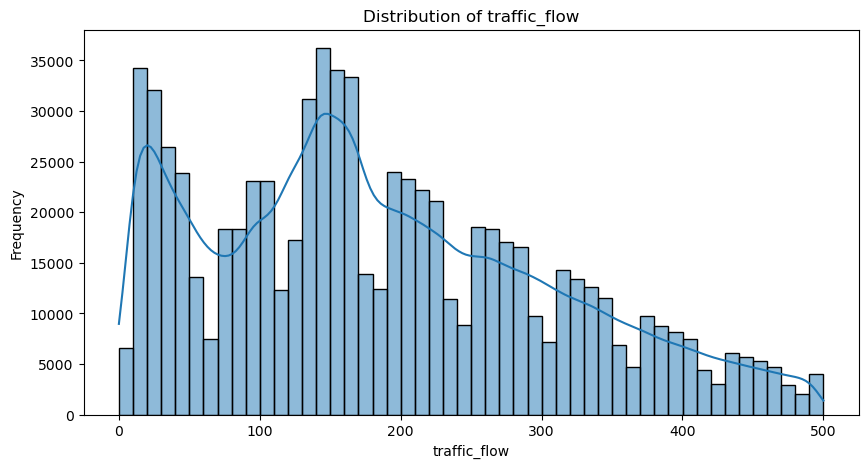

C:\Users\aio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


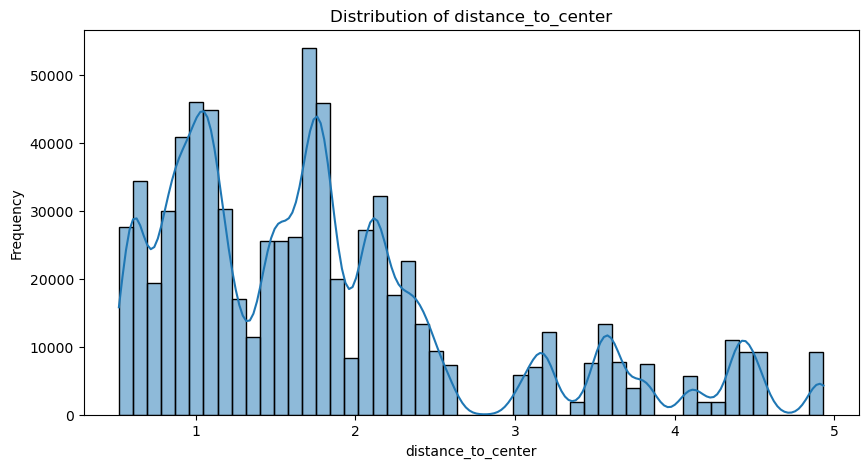

C:\Users\aio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


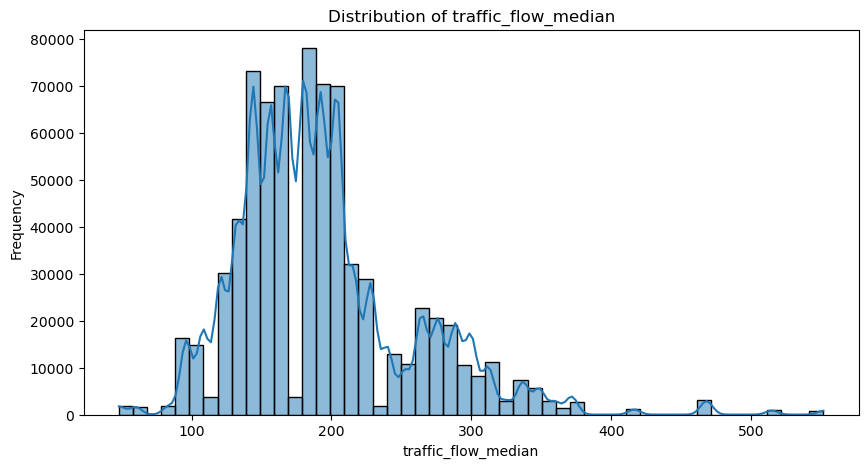

C:\Users\aio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


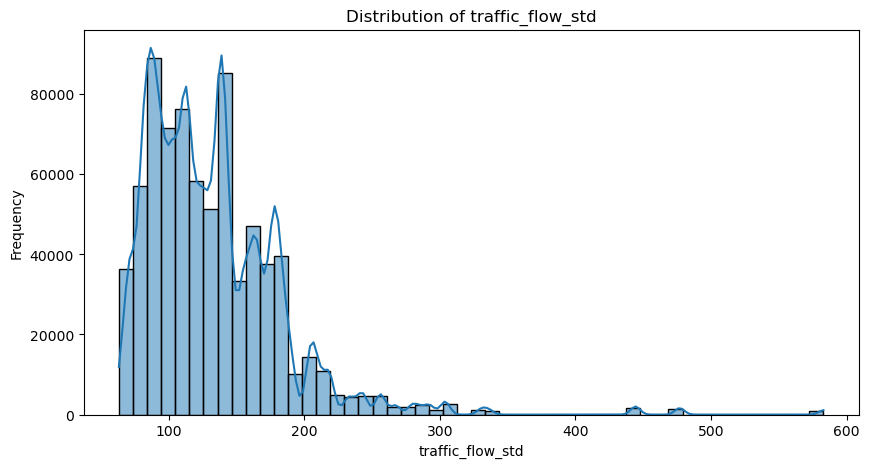

In [127]:
# Histogram for continuous variables
numeric_features = ['traffic_flow', 'distance_to_center', 'traffic_flow_median', 'traffic_flow_std']

for feature in numeric_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_cleaned[feature], kde=True, bins=50)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


- Boxplot To identify outliers in the traffic_flow, grouped by categorical variables like incident or

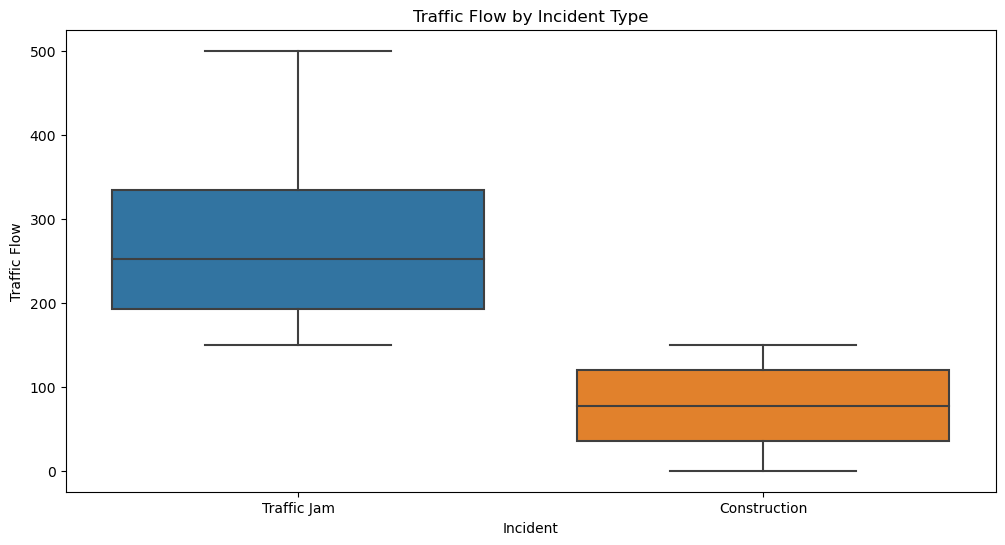

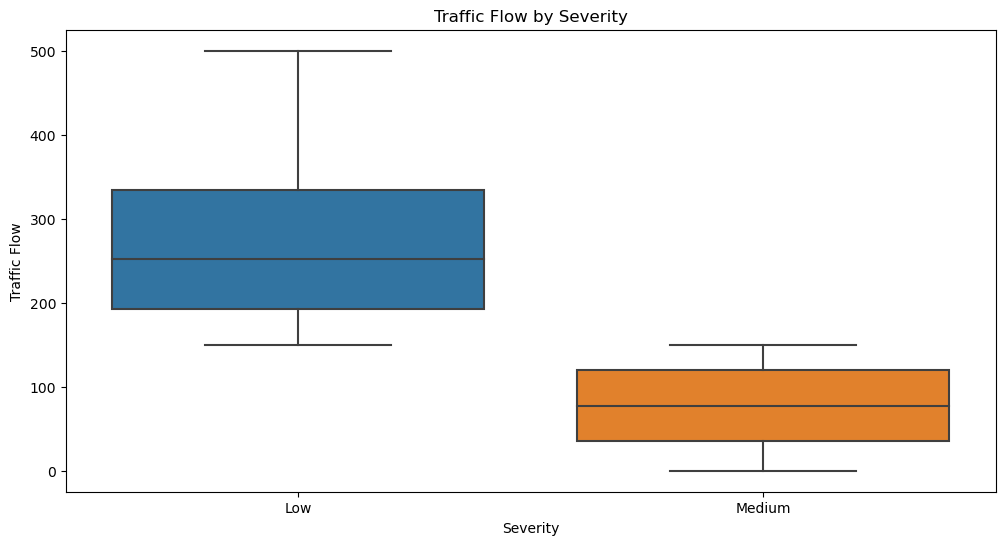

In [129]:
# Boxplot for traffic_flow by incident
plt.figure(figsize=(12, 6))
sns.boxplot(x='incident', y='traffic_flow', data=df_cleaned)
plt.title('Traffic Flow by Incident Type')
plt.xlabel('Incident')
plt.ylabel('Traffic Flow')
plt.show()

# Boxplot for traffic_flow by severity
plt.figure(figsize=(12, 6))
sns.boxplot(x='severity', y='traffic_flow', data=df_cleaned)
plt.title('Traffic Flow by Severity')
plt.xlabel('Severity')
plt.ylabel('Traffic Flow')
plt.show()


-  Bivariate Analysis Scatter Plots To examine the relationship between traffic_flow and other numerical variables:

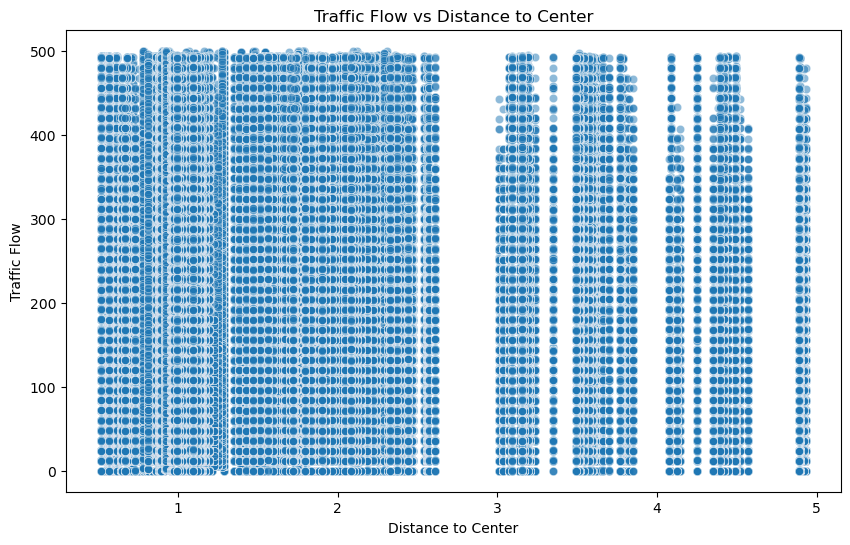

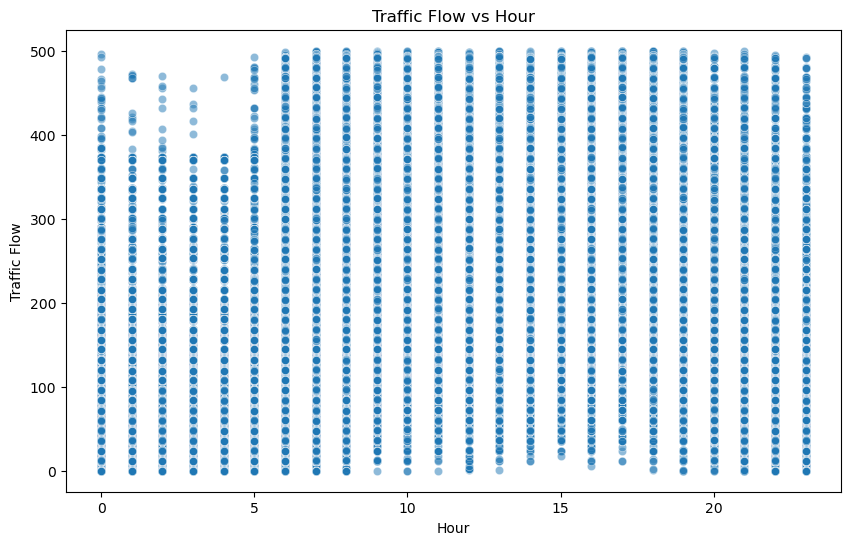

In [130]:
# Scatter plot for traffic_flow vs. distance_to_center
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_to_center', y='traffic_flow', data=df_cleaned, alpha=0.5)
plt.title('Traffic Flow vs Distance to Center')
plt.xlabel('Distance to Center')
plt.ylabel('Traffic Flow')
plt.show()

# Scatter plot for traffic_flow vs. hour
plt.figure(figsize=(10, 6))
sns.scatterplot(x='hour', y='traffic_flow', data=df_cleaned, alpha=0.5)
plt.title('Traffic Flow vs Hour')
plt.xlabel('Hour')
plt.ylabel('Traffic Flow')
plt.show()


- Heatmap for Correlations
- To analyze correlations among numerical features:

In [131]:
# Compute correlation matrix
correlation_matrix = df_cleaned.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


ValueError: could not convert string to float: 'high'

3. Time-based Patterns
- Line Plot
- To analyze traffic patterns over time (e.g., across hours, days, or months):

C:\Users\aio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\aio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


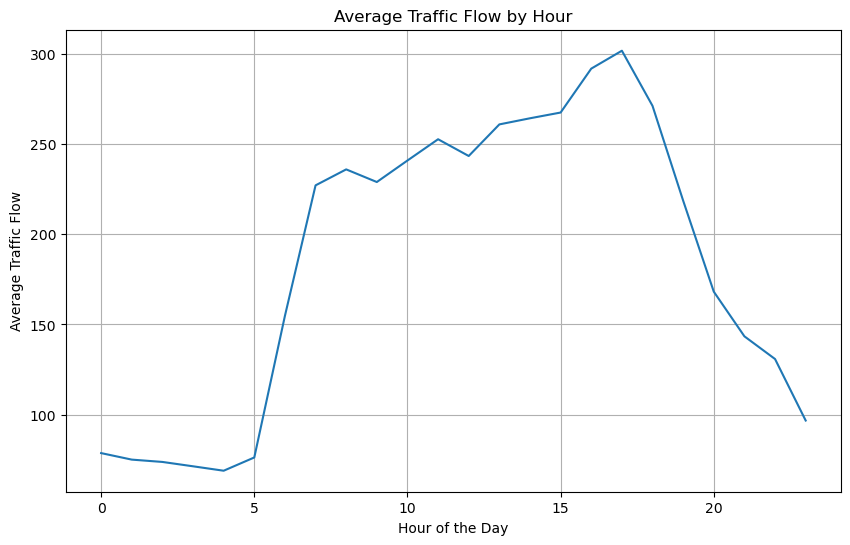

C:\Users\aio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\aio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


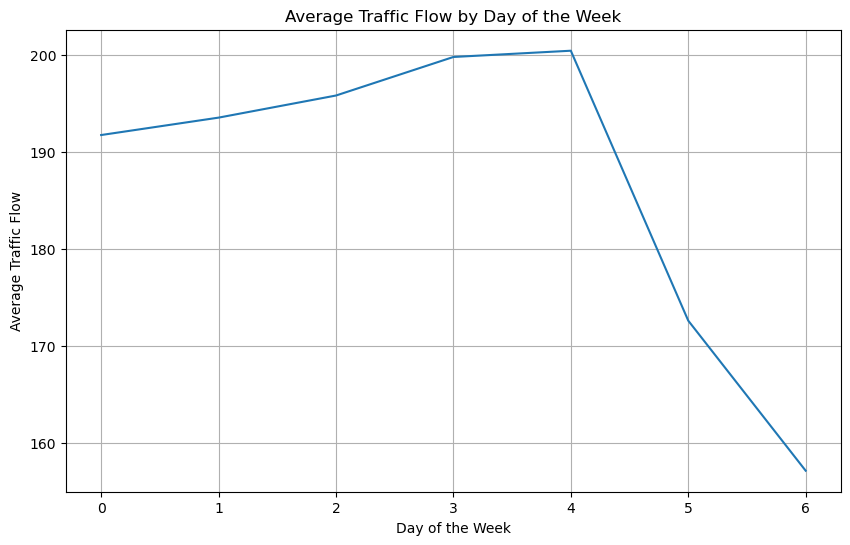

In [132]:
# Line plot for hourly traffic patterns
hourly_data = df_cleaned.groupby('hour')['traffic_flow'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='traffic_flow', data=hourly_data)
plt.title('Average Traffic Flow by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Traffic Flow')
plt.grid()
plt.show()

# Line plot for daily traffic patterns
daily_data = df_cleaned.groupby('day_of_week')['traffic_flow'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='day_of_week', y='traffic_flow', data=daily_data)
plt.title('Average Traffic Flow by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Traffic Flow')
plt.grid()
plt.show()


- Seasonal Decomposition
- To detect trends and seasonality in the traffic_flow variable:



In [133]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming the data is time-ordered and includes a timestamp column named 'timestamp'
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])  # Ensure timestamp is in datetime format
df_cleaned.set_index('timestamp', inplace=True)

# Resample data to hourly or daily frequency (as appropriate)
traffic_series = df_cleaned['traffic_flow'].resample('H').mean()

# Perform seasonal decomposition
decomposition = seasonal_decompose(traffic_series, model='additive', period=24)  # Adjust period as needed
decomposition.plot()
plt.show()


KeyError: 'timestamp'